In [1]:
# Parameters
notebook_fname = "NN_full_v3_BO_test_5"
data_path = "../01_Dataset_Cleaned/"
model_path = "../04_Model_Saved/"


In [2]:
# # Parameters
# notebook_fname = "NN_full_v3_BO_test_0"
# data_path = '../01_Dataset_Cleaned/'
# model_path = '../04_Model_Saved/'

# main notebook to train and evaluate the machine learning model


In [3]:
import os
import sys
sys.path.append("..")
sys.path.append("../..")

current_directory = os.getcwd()
print("Current directory:", current_directory)


Current directory: /nethome/home3/yuxiang.wu/v6_A-B-C-D-E_Sputtering/CCA_CALPHAD_SSS_ML/CCA_representation_ML/05_Model_BO_batch


In [4]:
# basic machine learning libaries
import os
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Concatenate, Dropout, BatchNormalization
from keras.utils.vis_utils import plot_model

# Data processing and plotting
import numpy as np
from numpy import asarray
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.pyplot import figure
from tabulate import tabulate

# Bayesian Optimization
import GPyOpt

# Parellisation
from multiprocessing import Pool
from joblib import Parallel, delayed
import concurrent.futures

# Miscellaneous
import importlib
import pickle
import time
# import warnings
# warnings.filterwarnings("ignore")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}

print(f'cpu_count: {os.cpu_count()}')

# Data Path
if os.path.isfile(data_path+'LiteratureDataset_Corrosion_YW_v3_processed.xlsx'):
    print(f"Folder '{os.path.abspath(data_path)}' found.")
else:
    print(f"Warning: File '{data_path}' not found!")

# Setting up multiple path for parallel Bayesian Optimization
num_str = notebook_fname.split("_")[-1]  # get the last string after "_"

try:
    bo_ens_num = int(num_str)
    print(f"bo_ens_num: {bo_ens_num}")
except ValueError:
    # if the string can't be converted to an integer, keep it as a string
    bo_ens_num = int(123)
    print(f"book master - bo_ens_num: {bo_ens_num}")

# model path
model_path_bo = f'{model_path}{notebook_fname}/'

if not os.path.exists(model_path_bo):
    os.makedirs(model_path_bo)
    print(f"Folder '{os.path.abspath(model_path_bo)}' created.")
else:
    print(f"Folder '{os.path.abspath(model_path_bo)}' already exists.")

# Cleaning up previous tensorflow sessions
tf.keras.backend.clear_session()


2023-08-16 21:31:39.731236: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2023-08-16 21:31:42.150966: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-08-16 21:31:42.151406: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-08-16 21:31:42.151422: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


cpu_count: 40
Folder '/nethome/home3/yuxiang.wu/v6_A-B-C-D-E_Sputtering/CCA_CALPHAD_SSS_ML/CCA_representation_ML/01_Dataset_Cleaned' found.
bo_ens_num: 5
Folder '/nethome/home3/yuxiang.wu/v6_A-B-C-D-E_Sputtering/CCA_CALPHAD_SSS_ML/CCA_representation_ML/04_Model_Saved/NN_full_v3_BO_test_5' already exists.


## functionality control


In [5]:
# functionality control of the notebook
Flag_Preprocessing = True
Flag_Training_try = False
Flag_BO_search = True
Flag_Training_BO_best = True
Flag_Evaluation = True
Flag_Prediction = True

# Use GPU or not
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
print('not using GPU')


not using GPU


## Import hardness and corrosion dataset


In [6]:
# Declare column names for the chemical composition dataframe, specific testing conditions, selected features, and output for Hardness and Corrosion datasets.
compo_column = ['Fe', 'Cr', 'Ni', 'Mo', 'W', 'N', 'Nb', 'C', 'Si',
                'Mn', 'Cu', 'Al', 'V', 'Ta', 'Ti', 'Co', 'Mg', 'Y', 'Zr', 'Hf']
C_specific_testing_column = ['TestTemperature_C',
                             'ChlorideIonConcentration', 'pH', 'ScanRate_mVs']
specific_features_sel_column = ['delta_a', 'Tm', 'sigma_Tm',
                                'Hmix', 'sigma_Hmix', 'sigma_elec_nega', 'VEC', 'sigma_VEC']
H_output_column = ['converted HV']
C_output_column = ['AvgPittingPotential_mV']

# Load the Hardness and Corrosion datasets
df_H = pd.read_excel(
    data_path + 'LiteratureDataset_Hardness_YW_v3_processed.xlsx')
df_C = pd.read_excel(
    data_path + 'LiteratureDataset_Corrosion_YW_v3_processed.xlsx')

# Partition the datasets into component composition, specific features, and output data
df_H_compo, df_H_specific_features, df_H_output = df_H[compo_column], df_H[
    specific_features_sel_column], df_H[H_output_column]
(df_C_compo, df_C_specific_testing, df_C_specific_features,
 df_C_output) = df_C[compo_column], df_C[C_specific_testing_column], df_C[specific_features_sel_column], df_C[C_output_column]

df_H_compo_specific_features = pd.concat(
    [df_H_compo, df_H_specific_features], axis=1)
df_C_compo_specific_features = pd.concat(
    [df_C_compo, df_C_specific_features], axis=1)


## Data preprocessing

**hardness network**

- input (X1): df_H_compo
- input (Y1):
- input (V1): df_H_specific_features
- output(H1): df_H_output

**corrosion network**

- input (X2): df_C_compo
- input (Z2): df_C_specific_testing
- input (W2): df_C_specific_features
- output(C2): df_C_output

### Obtain the MinMaxScaler from normalisation


In [7]:
if Flag_Preprocessing:

    # create an empty dataframe
    df_H_specific_testing = pd.DataFrame()

    # Prepare data for NN
    dfs = [df_H_compo, df_H_specific_testing, df_H_specific_features, df_H_output,
           df_C_compo, df_C_specific_testing, df_C_specific_features, df_C_output]

    # Convert DataFrames to numpy arrays
    inputs_outputs = [np.asarray(df.values) for df in dfs]

    # Define each variable
    (X1, Y1, V1, H1,
     X2, Z2, W2, C2) = inputs_outputs

    # Initialize MinMaxScalers for each data set
    scalers = {
        "compo": MinMaxScaler(),
        "H_specific_testing": MinMaxScaler(),
        "C_specific_testing": MinMaxScaler(),
        "specific_features": MinMaxScaler(),
        "H_output": MinMaxScaler(),
        "C_output": MinMaxScaler()
    }

    # Fit scalers to appropriate data
    scalers["compo"].fit(np.concatenate((X1, X2)))
    if Y1.size != 0:  # if Y1 is empty
        scalers["H_specific_testing"].fit(Y1)
    scalers["C_specific_testing"].fit(Z2)
    scalers["specific_features"].fit(np.concatenate((V1, W2)))
    scalers["H_output"].fit(H1.reshape((-1, 1)))
    scalers["C_output"].fit(C2.reshape((-1, 1)))

    print(scalers)

    # Save the scalers dictionary to a file using pickle
    with open(data_path + 'scalers.pkl', 'wb') as f:
        pickle.dump(scalers, f)


{'compo': MinMaxScaler(), 'H_specific_testing': MinMaxScaler(), 'C_specific_testing': MinMaxScaler(), 'specific_features': MinMaxScaler(), 'H_output': MinMaxScaler(), 'C_output': MinMaxScaler()}


### RepeatedKFold train-test split

- for hardness: `kfold_with_norm_H`

  - `X1_train_KFold`, `X1_test_KFold`,
  - (empty array)
  - `V1_train_KFold`, `V1_test_KFold`,
  - `H1_train_KFold`, `H1_test_KFold` as lists used in model training

- for corrosion: `kfold_with_norm_C`
  - `X2_train_KFold`, `X2_test_KFold`,
  - `Z2_train_KFold`, `Z2_test_KFold`,
  - `W2_train_KFold`, `W2_test_KFold`,
  - `C2_train_KFold`, `C2_test_KFold` as lists used in model training


In [8]:
if Flag_Preprocessing:

    from utils.preprocessing_kfold_norm import kfold_with_norm_H, kfold_with_norm_C

    n_splits, n_repeats, random_state = 6, 2, 42

    # for hardness network
    ([X1_train_KFold, V1_train_KFold, H1_train_KFold],
     [X1_test_KFold, V1_test_KFold, H1_test_KFold],
     [X1_train_norm_KFold, V1_train_norm_KFold, H1_train_norm_KFold],
     [X1_test_norm_KFold, V1_test_norm_KFold, H1_test_norm_KFold]) = kfold_with_norm_H(X1, V1, H1,
                                                                                       scalers["compo"], scalers[
                                                                                           "specific_features"], scalers["H_output"],
                                                                                       n_splits, n_repeats, random_state)

    # for corrosion network
    ([X2_train_KFold, Z2_train_KFold, W2_train_KFold, C2_train_KFold],
     [X2_test_KFold, Z2_test_KFold, W2_test_KFold, C2_test_KFold],
     [X2_train_norm_KFold, Z2_train_norm_KFold,
        W2_train_norm_KFold, C2_train_norm_KFold],
     [X2_test_norm_KFold, Z2_test_norm_KFold, W2_test_norm_KFold, C2_test_norm_KFold]) = kfold_with_norm_C(X2, Z2, W2, C2,
                                                                                                           scalers["compo"], scalers["C_specific_testing"], scalers[
                                                                                                               "specific_features"], scalers["C_output"],
                                                                                                           n_splits, n_repeats, random_state)


### Plot the histogram of train/test data for each split

- Plotting hardness train/test datasets
- Plotting corrosion train/test datasets


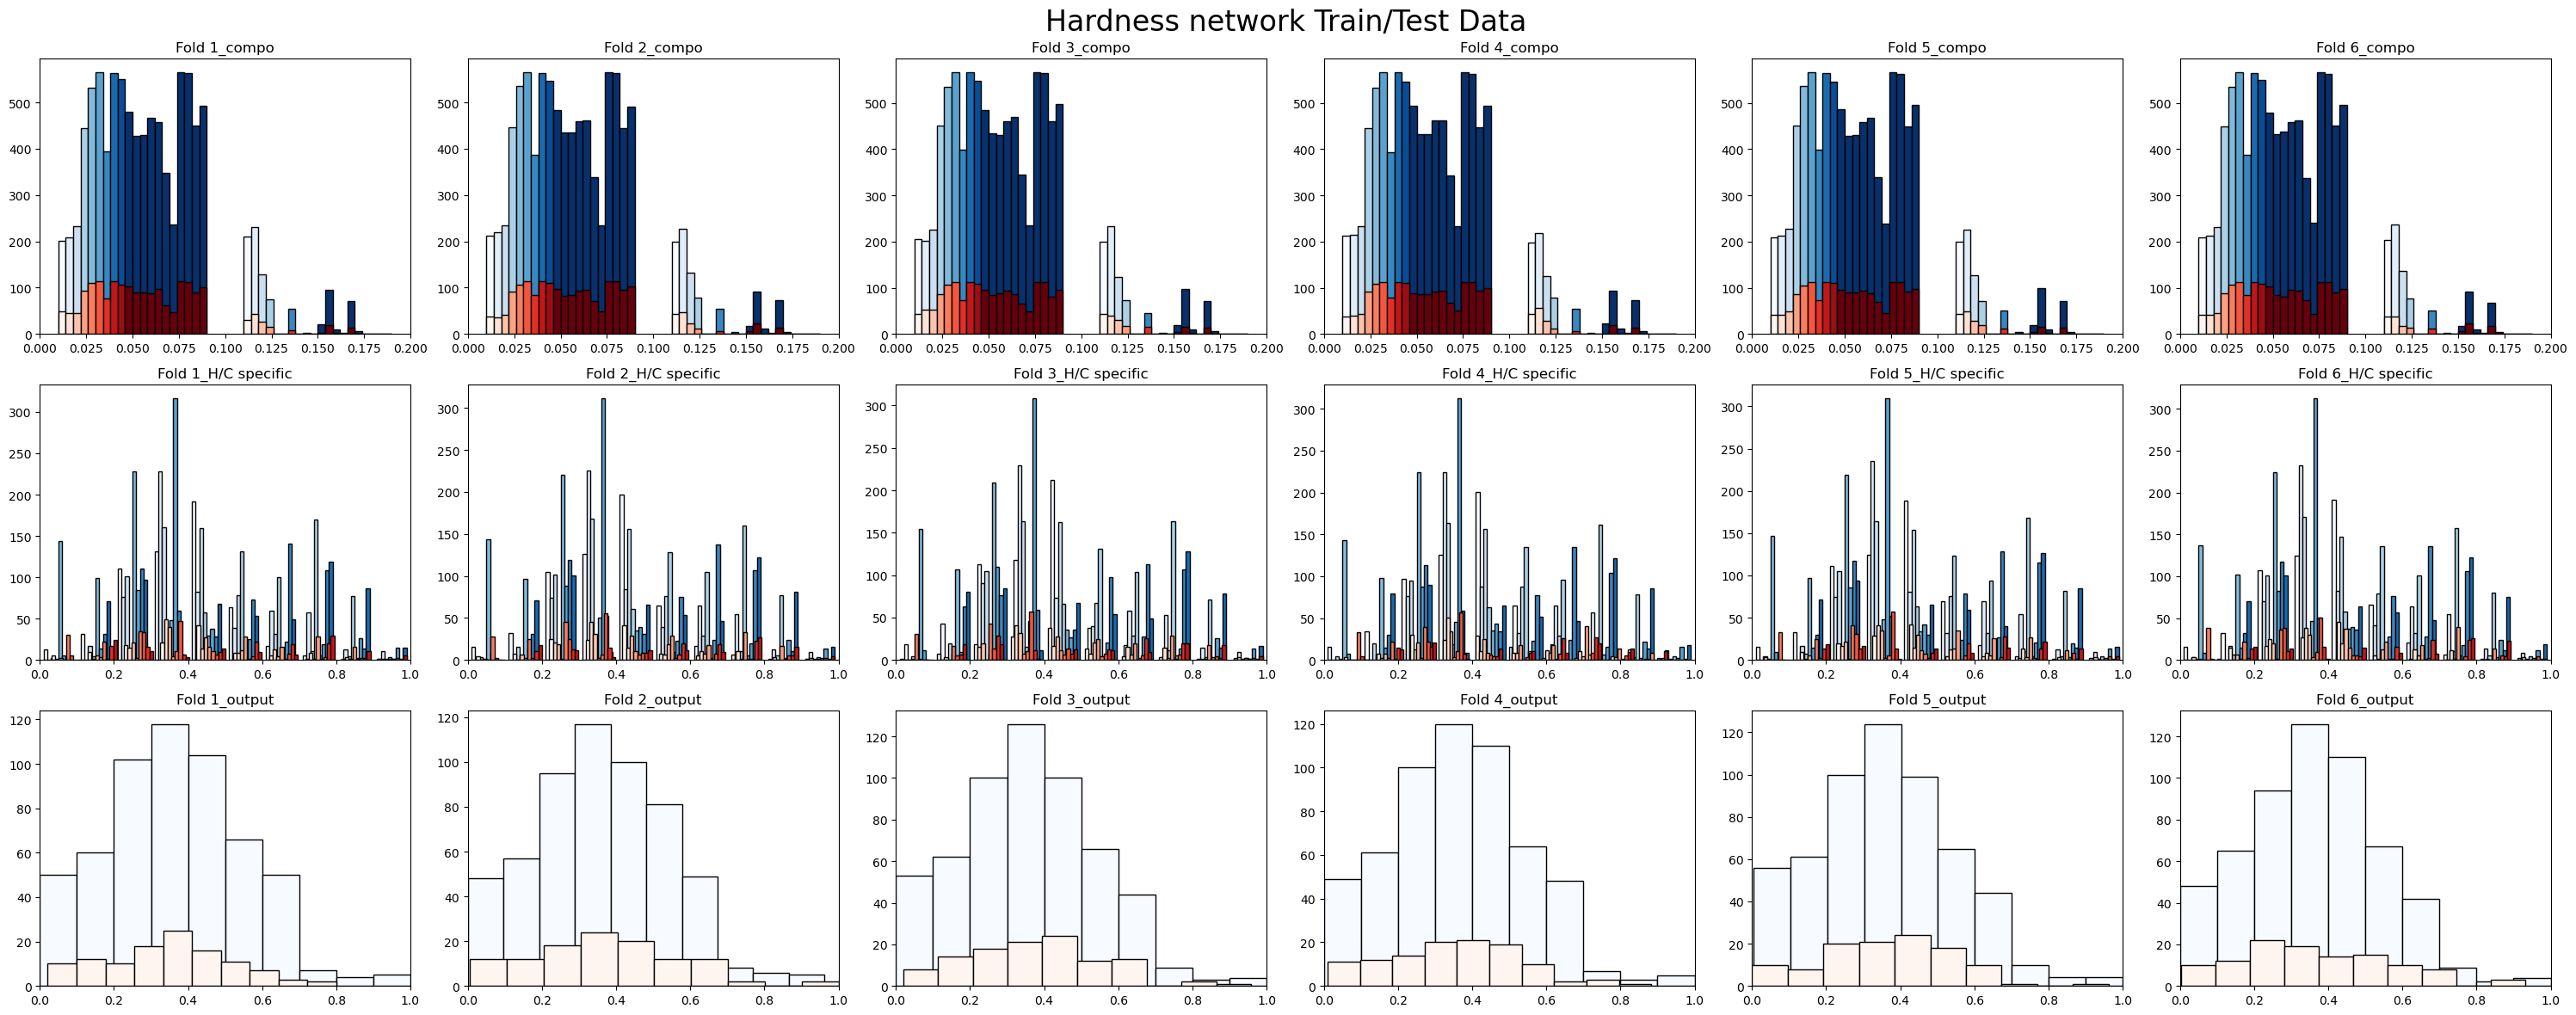

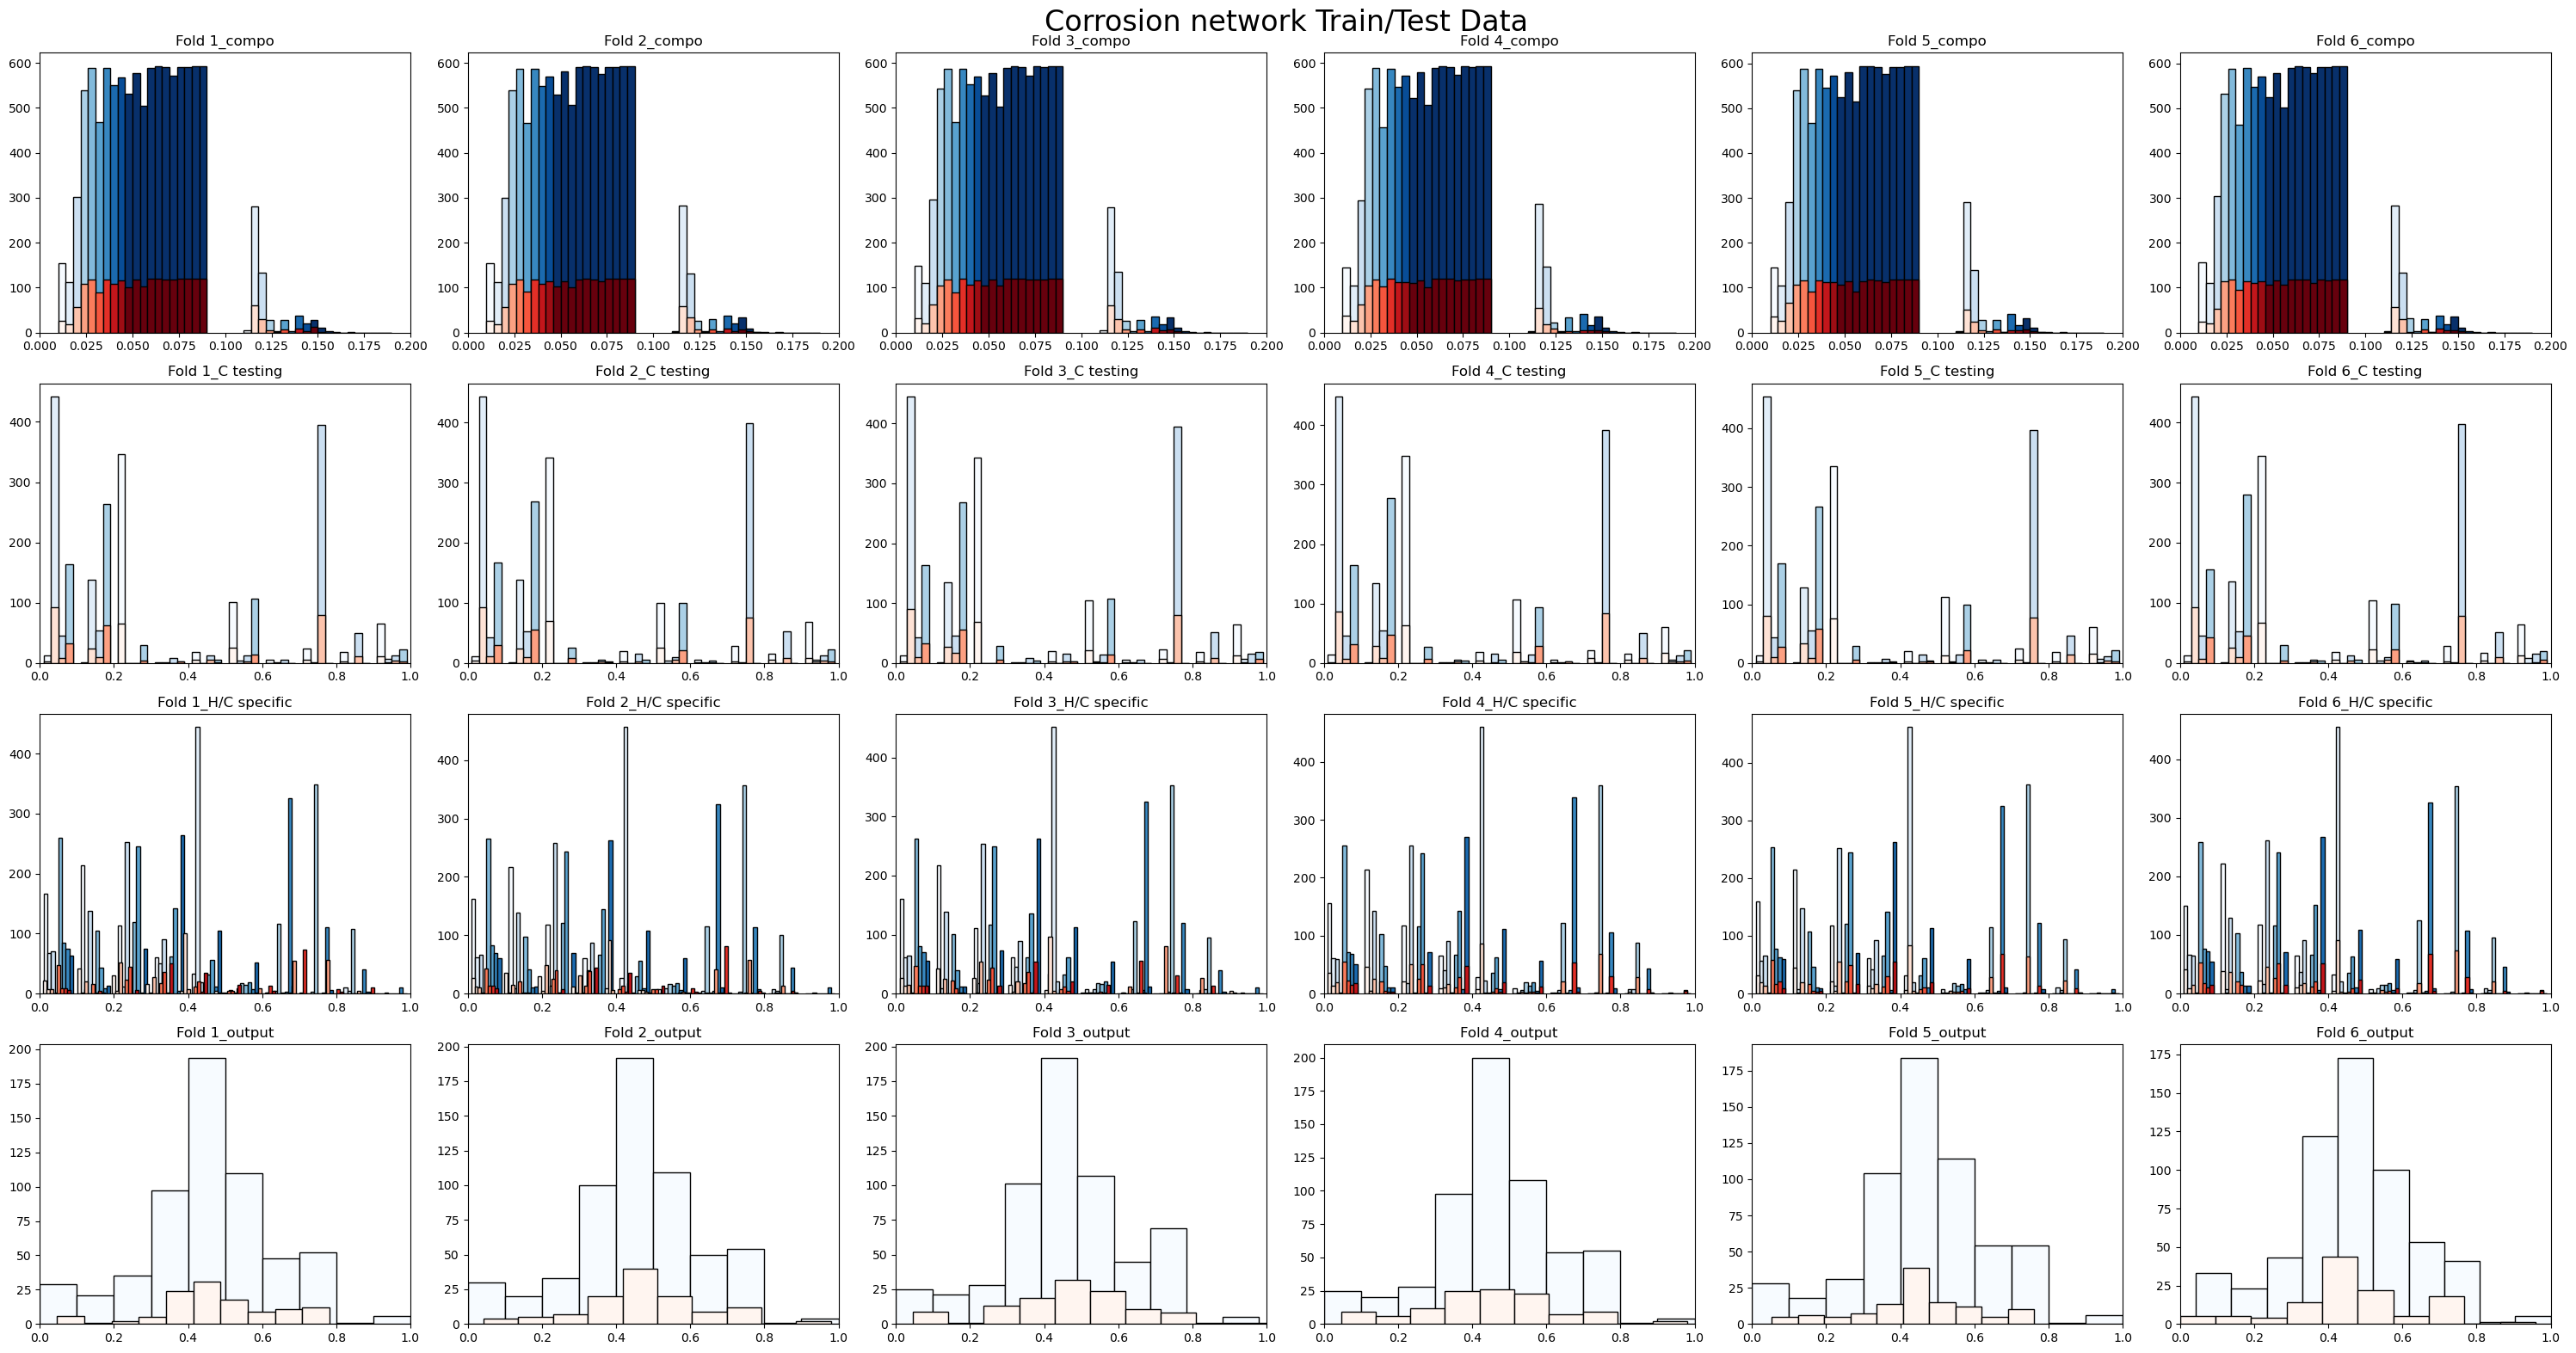

In [9]:
if Flag_Preprocessing:

    from utils.preprocessing_kfold_norm import plot_hist_kfold_with_norm

    # call the function to plot the histograms - hardness network
    plot_hist_kfold_with_norm(train_data=(X1_train_norm_KFold, V1_train_norm_KFold, H1_train_norm_KFold),
                              test_data=(X1_test_norm_KFold,
                                         V1_test_norm_KFold,  H1_test_norm_KFold),
                              x_min=(0, 0, 0),
                              x_max=(0.2, 1, 1),
                              axs_title='Hardness network Train/Test Data',
                              n_splits=6, n_repeats=1, nrows=3, dataset='H')

    # call the function to plot the histograms - corrosion network
    plot_hist_kfold_with_norm(train_data=(X2_train_norm_KFold, Z2_train_norm_KFold, W2_train_norm_KFold, C2_train_norm_KFold),
                              test_data=(X2_test_norm_KFold,  Z2_test_norm_KFold,
                                         W2_test_norm_KFold, C2_test_norm_KFold),
                              x_min=(0, 0, 0, 0),
                              x_max=(0.2, 1, 1, 1),
                              axs_title='Corrosion network Train/Test Data',
                              n_splits=6, n_repeats=1, nrows=4, dataset='C')


## NN architecture, creation, evaluation:

- shared feature NN: NNF
- hardness NN: NNH
- corrosion NN: NNC

class: `MultiTaskNN`

```
       input2-->|
                |-->NNH-->output_H
                |
 input1-->NNF-->|
                |
                |-->NNC-->output_C
       input3-->|
```


### Using `MultiTaskNN` class for training


In [10]:
if Flag_Training_try:

    from utils.multitask_nn import MultiTaskNN

    start_time = time.time()
    mt_nn = MultiTaskNN(NNF_num_nodes=64, NNF_num_layers=0,
                        NNH_num_nodes=64, NNH_num_layers=4,
                        NNC_num_nodes=64, NNC_num_layers=3,
                        mc_state=True, act='relu',
                        NNF_dropout=0.25, NNH_dropout=0.25, NNC_dropout=0.25,
                        loss_func=tf.keras.metrics.mean_squared_error,
                        learning_rate_H=0.001, learning_rate_C=0.001,
                        batch_size_H=32,
                        N_epochs_local=1, total_epochs=1000,
                        model_save_flag=True, model_path_bo=model_path_bo)

    # inputs for `RepeatedKFold`
    k_folds, n_CVrepeats = 6, 2

    # train_loss/val_loss: training/validation loss history
    # score_loss/score_r2: evaluated loss score/R2 score

    (train_loss_H, train_loss_C,
     val_loss_H,    val_loss_C,
     score_loss_H,  score_loss_C,
     score_r2_H,    score_r2_C) = mt_nn.evaluate_NN_full_model(X1_train_norm_KFold, X1_test_norm_KFold, V1_train_norm_KFold, V1_test_norm_KFold, H1_train_norm_KFold, H1_test_norm_KFold,
                                                               X2_train_norm_KFold, X2_test_norm_KFold, Z2_train_norm_KFold, Z2_test_norm_KFold, W2_train_norm_KFold, W2_test_norm_KFold, C2_train_norm_KFold, C2_test_norm_KFold,
                                                               k_folds, n_CVrepeats)
    elapsed_time = time.time() - start_time
    print("Time taken: ", int(elapsed_time), "seconds")


### Training quality for NNH_model and NNC_model


In [11]:
if Flag_Training_try:
    # training results by score_loss
    # print([f'{x:.4f}' for x in score_loss_H])
    # print([f'{x:.4f}' for i in range(12) for x in val_loss_H[i][-1]])
    print(
        f"score_loss_H: {np.mean(score_loss_H):.4f} ({np.std(score_loss_H):.4f})")

    # print([f'{x:.4f}' for x in score_loss_C])
    # print([f'{x:.4f}' for i in range(12) for x in val_loss_C[i][-1]])
    print(
        f"score_loss_C: {np.mean(score_loss_C):.4f} ({np.std(score_loss_C):.4f})")

    # training results by score_r2
    # print([f'{x:.4f}' for x in score_r2_H])
    print(
        f"score_r2_H:   {np.mean(score_r2_H):.4f} ({np.std(score_r2_H):.4f})")

    # print([f'{x:.4f}' for x in score_r2_C])
    print(f"score_r2_C: {np.mean(score_r2_C):.4f} ({np.std(score_r2_C):.4f})")

    print(f"score_r2_HC: {np.mean([score_r2_H, score_r2_C]):.4f}")


### Plot the loss history


In [12]:
if Flag_Training_try:
    mt_nn.plot_losses(train_loss_H, val_loss_H, train_loss_C,
                      val_loss_C, k_folds=6, n_CVrepeats=2)


## Bayesian Hyperparameter Optimisation

class: `BO_hyper_objective`


### Define the search domain


In [13]:
if Flag_BO_search:
    # Define the search space for hyperparameters

    # loss_encoder == 0: mean_squared_error
    # loss_encoder == 1: mean_absolute_error

    search_hyper_space = [{'name': 'NNF_num_nodes',   'type': 'discrete',  'domain': (32, 64, 128, 256)},  # 0: NNF_num_nodes
                          {'name': 'NNF_num_layers',  'type': 'discrete',
                           'domain': (1, 2, 3, 4, 5)},  # 1: NNF_num_layers
                          {'name': 'NNH_num_nodes',   'type': 'discrete',
                           'domain': (32, 64, 128)},    # 2: NNH_num_nodes
                          {'name': 'NNH_num_layers',  'type': 'discrete',
                           'domain': (1, 2, 3)},        # 3: NNH_num_layers
                          {'name': 'NNC_num_nodes',   'type': 'discrete',
                           'domain': (32, 64, 128)},    # 4: NNC_num_nodes
                          {'name': 'NNC_num_layers',  'type': 'discrete',
                           'domain': (1, 2, 3)},        # 5: NNC_num_layers
                          {'name': 'learning_rate_H', 'type': 'continuous',
                           'domain': (0.0001, 0.0005)},    # 9: learning_rate_H
                          {'name': 'learning_rate_C', 'type': 'continuous',
                           'domain': (0.0001, 0.0005)},    # 10: learning_rate_C
                          {'name': 'batch_size_H',    'type': 'discrete',
                           'domain': (16, 32, 64)},        # 11: batch_size_H
                          {'name': 'N_epochs_local',  'type': 'discrete',  'domain': (1, 2, 3)}]  # 12: N_epochs_global

    fixed_hyper_space = [{'name': 'NNF_dropout',     'type': 'continuous',
                          'domain': (0.1)},            # 6: NNF_dropout
                         {'name': 'NNH_NNC_dropout', 'type': 'continuous',
                          'domain': (0.1)},            # 7: NNH_NNC_dropout
                         {'name': 'loss_encoder',      'type': 'discrete',
                          'domain': (0)}]               # 8: loss_encoder

    search_hyper_names = [entry['name'] for entry in search_hyper_space]
    fixed_hyper_names = [entry['name'] for entry in fixed_hyper_space]
    all_hyper_names = ['NNF_num_nodes', 'NNF_num_layers', 'NNH_num_nodes', 'NNH_num_layers', 'NNC_num_nodes', 'NNC_num_layers',
                       'NNF_dropout', 'NNH_NNC_dropout',  'loss_encoder', 'learning_rate_H',  'learning_rate_C',   'batch_size_H', 'N_epochs_local']


### BO hyperparameter optimisation


In [14]:
if Flag_BO_search:
    from utils.BO_hyper_objective import BayesianOptimizationObjective

    start_time = time.time()

    # Set up the optimizer
    bo = None
    bo_iteration = 0
    np.random.seed(bo_ens_num)

    # Configuration settings for the model being optimized
    total_epochs = 1000
    n_initial_points, n_iterations = 10, 200

    mc_state, act = True, 'relu'
    model_save_flag = False
    k_folds, n_CVrepeats = 6, 2
    score_r2_HC_list, score_loss_HC_list, score_r2_H_list, score_r2_C_list, score_loss_H_list, score_loss_C_list = [], [], [], [], [], []

    # Instantiate the objective function class for Bayesian Optimization
    bo_obj = BayesianOptimizationObjective(
        bo_ens_num, model_path_bo, all_hyper_names, search_hyper_names)

    # Set up and configure Bayesian Optimization using GPyOpt
    bo = GPyOpt.methods.BayesianOptimization(f=lambda x: bo_obj.BO_NNF_NNH_NNC_objective(x, fixed_hyper_space, search_hyper_names, fixed_hyper_names,
                                                                                         n_initial_points, n_iterations,
                                                                                         mc_state, act,
                                                                                         total_epochs,
                                                                                         model_save_flag, model_path_bo,
                                                                                         X1_train_norm_KFold, X1_test_norm_KFold, V1_train_norm_KFold, V1_test_norm_KFold, H1_train_norm_KFold, H1_test_norm_KFold,
                                                                                         X2_train_norm_KFold, X2_test_norm_KFold, Z2_train_norm_KFold, Z2_test_norm_KFold, W2_train_norm_KFold, W2_test_norm_KFold, C2_train_norm_KFold, C2_test_norm_KFold,
                                                                                         k_folds, n_CVrepeats,
                                                                                         score_r2_HC_list, score_loss_HC_list,
                                                                                         score_r2_H_list, score_r2_C_list,
                                                                                         score_loss_H_list, score_loss_C_list)[0],  # Use only score_r2 as objective function
                                             domain=search_hyper_space,
                                             model_type='GP',
                                             initial_design_numdata=n_initial_points,
                                             init_design_type='random',
                                             acquisition_type='EI',
                                             acquisition_optimizer_type='lbfgs',
                                             maximize=True)

    # Start the optimization for the given number of iterations
    bo.run_optimization(max_iter=n_iterations)

    # Print the best hyperparameters and their corresponding objective value
    best_hyperparameters = ", ".join("{:.4f}".format(h) for h in bo.x_opt)
    print("Best hyperparameters: {}".format(best_hyperparameters))
    print("Best objective value:", -bo.fx_opt)

    # Calculate and display the elapsed time for the optimization
    elapsed_time = time.time() - start_time
    print("Time taken: ", int(elapsed_time), "seconds")

Iteration: 1/210


Iteration: 2/210


Iteration: 3/210


Iteration: 4/210


Iteration: 5/210


Iteration: 6/210


Iteration: 7/210


Iteration: 8/210


Iteration: 9/210


Iteration: 10/210


Iteration: 11/210


Iteration: 12/210


Iteration: 13/210


Iteration: 14/210


Iteration: 15/210


Iteration: 16/210


Iteration: 17/210


Iteration: 18/210


Iteration: 19/210


Iteration: 20/210


Iteration: 21/210


Iteration: 22/210


Iteration: 23/210


Iteration: 24/210


Iteration: 25/210


Iteration: 26/210


Iteration: 27/210


Iteration: 28/210


Iteration: 29/210


Iteration: 30/210


Iteration: 31/210


Iteration: 32/210


Iteration: 33/210


Iteration: 34/210


Iteration: 35/210


Iteration: 36/210


Iteration: 37/210


Iteration: 38/210


Iteration: 39/210


Iteration: 40/210


Iteration: 41/210


Iteration: 42/210


Iteration: 43/210


Iteration: 44/210


Iteration: 45/210


Iteration: 46/210


Iteration: 47/210


Iteration: 48/210


Iteration: 49/210


Iteration: 50/210


Iteration: 51/210


Iteration: 52/210


Iteration: 53/210


Iteration: 54/210


Iteration: 55/210


Iteration: 56/210


Iteration: 57/210


Iteration: 58/210


Iteration: 59/210


Iteration: 60/210


Iteration: 61/210


Iteration: 62/210


Iteration: 63/210


Iteration: 64/210


Iteration: 65/210


Iteration: 66/210


Iteration: 67/210


Iteration: 68/210


Iteration: 69/210


Iteration: 70/210


Iteration: 71/210


Iteration: 72/210


Iteration: 73/210


Iteration: 74/210


Iteration: 75/210


Iteration: 76/210


Iteration: 77/210


Iteration: 78/210


Iteration: 79/210


Iteration: 80/210


Iteration: 81/210


Iteration: 82/210


Iteration: 83/210


Iteration: 84/210


Iteration: 85/210


Iteration: 86/210


Iteration: 87/210


Iteration: 88/210


Best hyperparameters: 256.0000, 2.0000, 64.0000, 1.0000, 128.0000, 1.0000, 0.0004, 0.0004, 16.0000, 3.0000
Best objective value: 0.660316380310498
Time taken:  77094 seconds


### Save the BO hypertable


In [15]:
if Flag_BO_search:

    # update the hypertable
    bo_obj.update_hypertable(fixed_hyper_space, bo,
                             score_r2_HC_list, score_loss_HC_list,
                             score_r2_H_list, score_r2_C_list, score_loss_H_list, score_loss_C_list)

    # Save the sorted data to an Excel file
    bo_obj.hypertable.to_excel(model_path_bo +
                               f"hypertable_{notebook_fname}.xlsx", index=False)

    # sort the list start from the best results
    hypertable_sort = bo_obj.hypertable.sort_values(
        by=['score_r2_HC'], ascending=False, ignore_index=True)

    display(hypertable_sort.head())

    # Save the sorted data to an Excel file
    hypertable_sort.to_excel(model_path_bo +
                             f"hypertable_sort_{notebook_fname}.xlsx", index=False)


score_r2_HC  score_r2_HC_best  score_loss_HC  score_r2_H  score_r2_C  \
0     0.660316          0.660316       0.011355    0.630699    0.689934   
1     0.656197          0.660316       0.011479    0.641226    0.671168   
2     0.656102          0.660316       0.011531    0.624083    0.688122   
3     0.655677          0.655677       0.011472    0.636617    0.674738   
4     0.654879          0.660316       0.011549    0.617378    0.692381   

   score_loss_H  score_loss_C  NNF_num_nodes  NNF_num_layers  NNH_num_nodes  \
0      0.013340      0.009369          256.0             2.0           64.0   
1      0.012726      0.010232          256.0             3.0          128.0   
2      0.013496      0.009566          256.0             2.0           64.0   
3      0.012825      0.010119          256.0             3.0          128.0   
4      0.013769      0.009330          256.0             2.0           64.0   

   NNH_num_layers  NNC_num_nodes  NNC_num_layers  NNF_dropout  \
0             1.0          128.0             1.0          0.1   
1             1.0           32.0             2.0          0.1   
2             1.0          128.0             1.0          0.1   
3             1.0           32.0             2.0          0.1   
4             2.0          128.0             1.0          0.1   

   NNH_NNC_dropout  loss_encoder  learning_rate_H  learning_rate_C  \
0              0.1             0         0.000429         0.000416   
1              0.1             0         0.000500         0.000500   
2              0.1             0         0.000368         0.000352   
3              0.1             0         0.000500         0.000500   
4              0.1             0         0.000500         0.000500   

   batch_size_H  N_epochs_local  
0          16.0             3.0  
1          32.0             1.0  
2          16.0             2.0  
3          32.0             1.0  
4          16.0             3.0

### Plotting the BO process


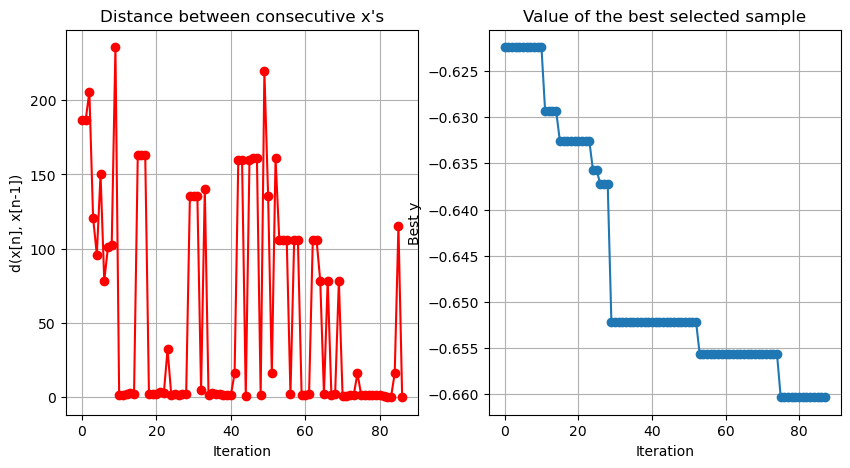

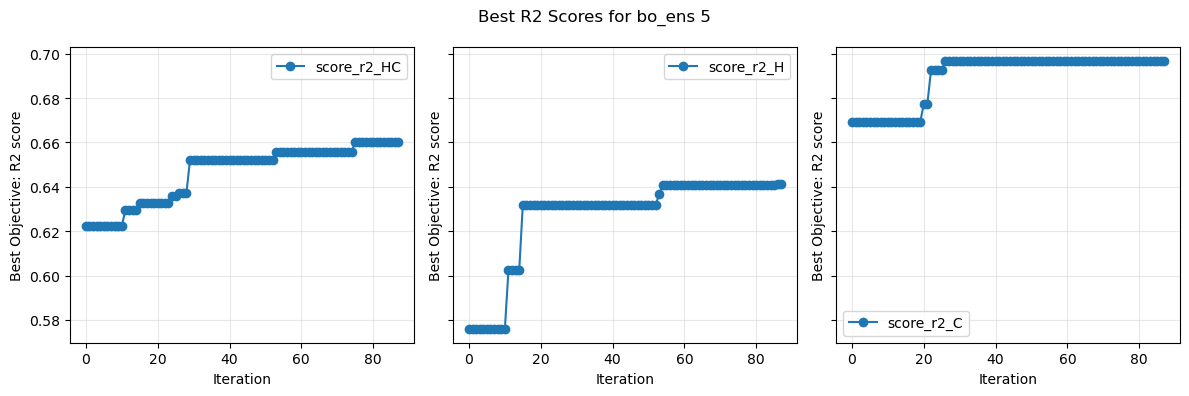

In [16]:
if Flag_BO_search:
    # plot the convergence
    bo.plot_convergence()

    bo_obj.plot_best_r2_score()


### Model training: using best BO hyperparameters


In [17]:
if Flag_Training_BO_best:

    from utils.multitask_nn import MultiTaskNN

    start_time = time.time()

    # loading the best BO hyperparameters
    hypertable_sort = pd.read_excel(
        model_path_bo + f"hypertable_sort_{notebook_fname}.xlsx")
    display(hypertable_sort.head(1))
    #
    # inputs for `RepeatedKFold`
    k_folds, n_CVrepeats = 6, 2

    loss_encoder = int(hypertable_sort.loc[0, 'loss_encoder'])
    if loss_encoder == 0:
        loss_func = tf.keras.metrics.mean_squared_error
    elif loss_encoder == 1:
        loss_func = tf.keras.metrics.mean_absolute_error
    else:
        raise ValueError(f"Invalid loss function '{loss_encoder}' ")

    mt_nn_BObest = MultiTaskNN(NNF_num_nodes=int(hypertable_sort.loc[0, 'NNF_num_nodes']), NNF_num_layers=int(hypertable_sort.loc[0, 'NNF_num_layers']),
                               NNH_num_nodes=int(hypertable_sort.loc[0, 'NNH_num_nodes']), NNH_num_layers=int(hypertable_sort.loc[0, 'NNH_num_layers']),
                               NNC_num_nodes=int(hypertable_sort.loc[0, 'NNC_num_nodes']), NNC_num_layers=int(hypertable_sort.loc[0, 'NNC_num_layers']),
                               mc_state=True, act='relu',
                               NNF_dropout=hypertable_sort.loc[0,
                                                               'NNF_dropout'],
                               NNH_dropout=hypertable_sort.loc[0,
                                                               'NNH_NNC_dropout'],
                               NNC_dropout=hypertable_sort.loc[0,
                                                               'NNH_NNC_dropout'],
                               loss_func=tf.keras.metrics.mean_squared_error,
                               learning_rate_H=hypertable_sort.loc[0,
                                                                   'learning_rate_H'],
                               learning_rate_C=hypertable_sort.loc[0,
                                                                   'learning_rate_C'],
                               batch_size_H=int(
                                   hypertable_sort.loc[0, 'batch_size_H']),
                               N_epochs_local=int(
                                   hypertable_sort.loc[0, 'N_epochs_local']),
                               total_epochs=5000,
                               model_save_flag=True, model_path_bo=model_path_bo)

    # evaluate model
    (train_loss_H, train_loss_C,
     val_loss_H,    val_loss_C,
     score_loss_H,  score_loss_C,
     score_r2_H,    score_r2_C) = mt_nn_BObest.evaluate_NN_full_model(X1_train_norm_KFold, X1_test_norm_KFold, V1_train_norm_KFold, V1_test_norm_KFold, H1_train_norm_KFold, H1_test_norm_KFold,
                                                                      X2_train_norm_KFold, X2_test_norm_KFold, Z2_train_norm_KFold, Z2_test_norm_KFold, W2_train_norm_KFold, W2_test_norm_KFold, C2_train_norm_KFold, C2_test_norm_KFold,
                                                                      k_folds, n_CVrepeats)

    elapsed_time = time.time() - start_time
    print("Time taken: ", int(elapsed_time), "seconds")

score_r2_HC  score_r2_HC_best  score_loss_HC  score_r2_H  score_r2_C  \
0     0.660316          0.660316       0.011355    0.630699    0.689934   

   score_loss_H  score_loss_C  NNF_num_nodes  NNF_num_layers  NNH_num_nodes  \
0       0.01334      0.009369            256               2             64   

   NNH_num_layers  NNC_num_nodes  NNC_num_layers  NNF_dropout  \
0               1            128               1          0.1   

   NNH_NNC_dropout  loss_encoder  learning_rate_H  learning_rate_C  \
0              0.1             0         0.000429         0.000416   

   batch_size_H  N_epochs_local  
0            16               3

Time taken:  3015 seconds


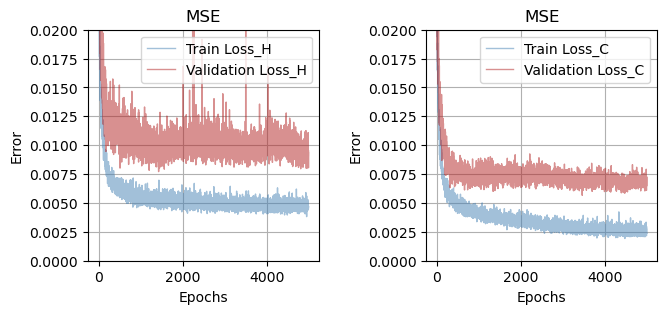

In [18]:
if Flag_Training_BO_best:

    mt_nn_BObest.plot_losses(train_loss_H, val_loss_H, train_loss_C,
                             val_loss_C, k_folds=6, n_CVrepeats=2)


## Evaluate the training results

- Show the model.h5 files in this directory
- Load scalers


In [19]:
import pickle
from utils.postprocessing_evalutation import display_saved_models

display_saved_models(model_path_bo)

# Load the scalers dictionary from a file using pickle
with open(data_path + 'scalers.pkl', 'rb') as f:
    scalers = pickle.load(f)
    print("")
print(scalers)


NNH_model                      NNC_model
-----------------------------  -----------------------------
NNH_model_RepeatedKFold_1.h5   NNC_model_RepeatedKFold_1.h5
NNH_model_RepeatedKFold_2.h5   NNC_model_RepeatedKFold_2.h5
NNH_model_RepeatedKFold_3.h5   NNC_model_RepeatedKFold_3.h5
NNH_model_RepeatedKFold_4.h5   NNC_model_RepeatedKFold_4.h5
NNH_model_RepeatedKFold_5.h5   NNC_model_RepeatedKFold_5.h5
NNH_model_RepeatedKFold_6.h5   NNC_model_RepeatedKFold_6.h5
NNH_model_RepeatedKFold_7.h5   NNC_model_RepeatedKFold_7.h5
NNH_model_RepeatedKFold_8.h5   NNC_model_RepeatedKFold_8.h5
NNH_model_RepeatedKFold_9.h5   NNC_model_RepeatedKFold_9.h5
NNH_model_RepeatedKFold_10.h5  NNC_model_RepeatedKFold_10.h5
NNH_model_RepeatedKFold_11.h5  NNC_model_RepeatedKFold_11.h5
NNH_model_RepeatedKFold_12.h5  NNC_model_RepeatedKFold_12.h5

{'compo': MinMaxScaler(), 'H_specific_testing': MinMaxScaler(), 'C_specific_testing': MinMaxScaler(), 'specific_features': MinMaxScaler(), 'H_output': MinMaxScaler(), 'C_outp

### Plot true vs predictions (test data) for each RepeatedKFold


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosi

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosi

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


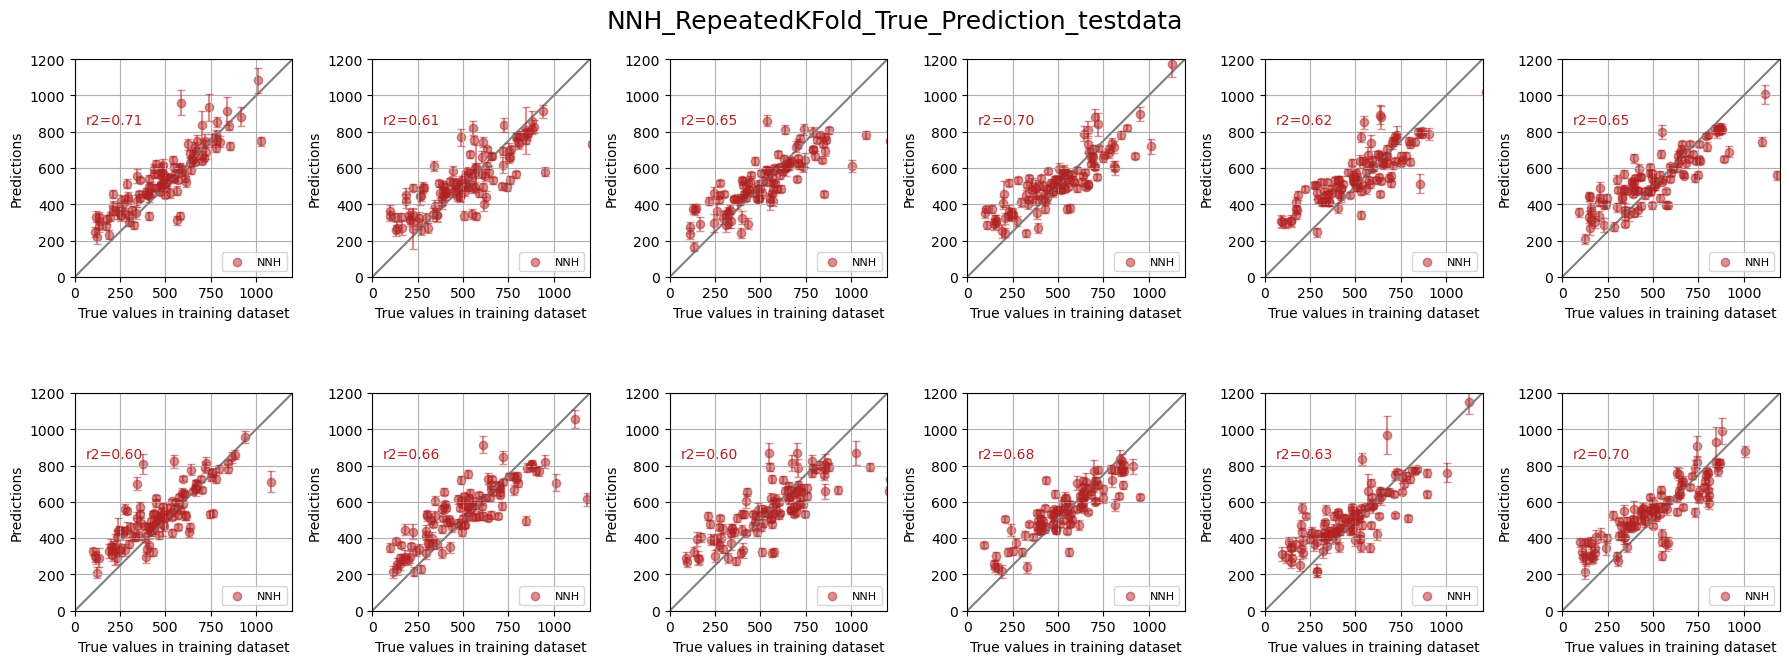

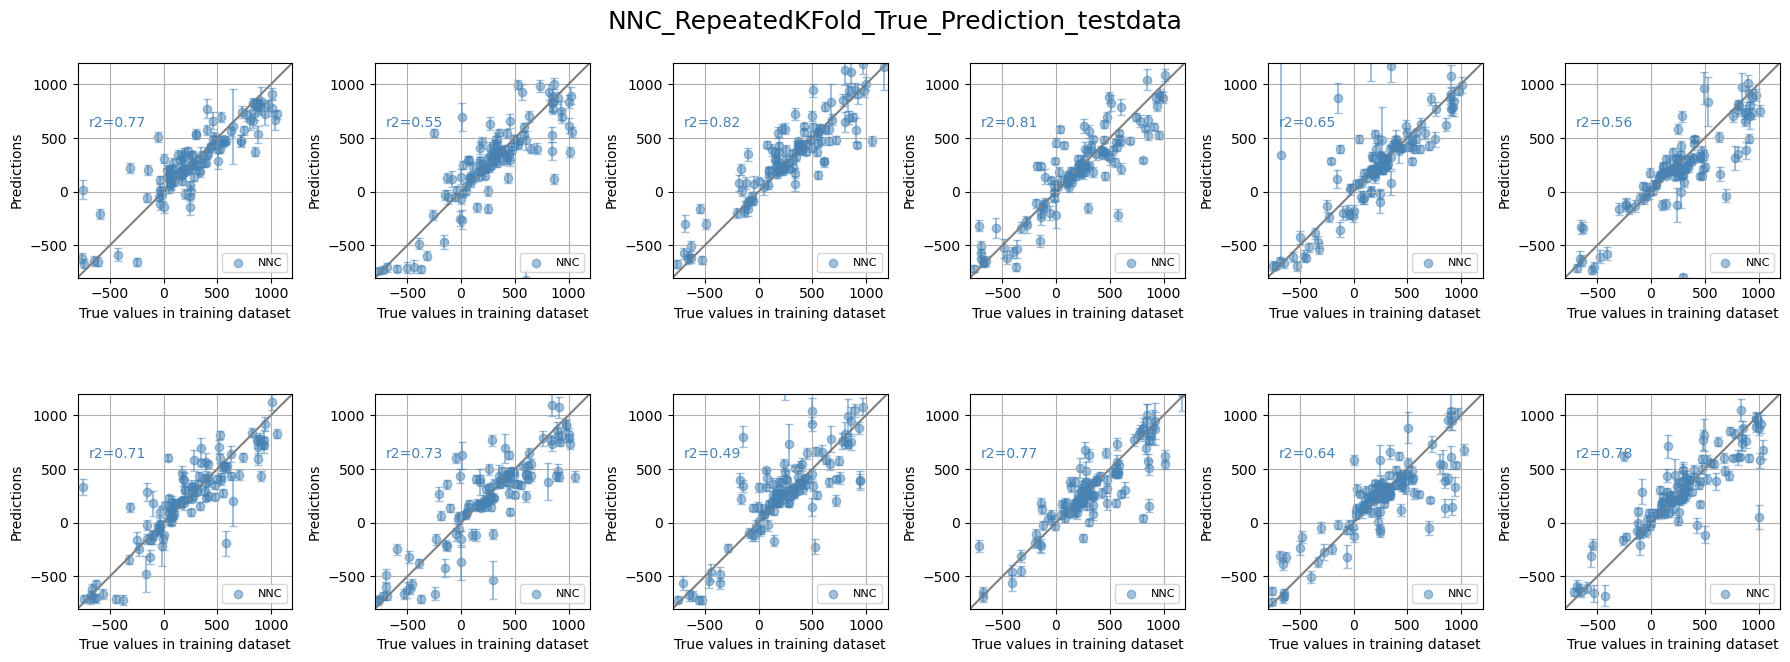

In [20]:
if Flag_Evaluation:

    from utils.postprocessing_evalutation import predict_bootstrap, plot_test_true_vs_pred

    NNH_model_name, NNC_model_name = 'NNH_model_RepeatedKFold_{}.h5', 'NNC_model_RepeatedKFold_{}.h5'
    k_folds, n_CVrepeats, mc_repeat = 6, 2, 50

    with concurrent.futures.ThreadPoolExecutor() as executor:
        future1 = executor.submit(predict_bootstrap, model_path_bo, NNH_model_name,
                                  X1_test_KFold, [], V1_test_KFold,
                                  k_folds, n_CVrepeats, mc_repeat,
                                  scalers["compo"], [], scalers["specific_features"], scalers["H_output"])

        future2 = executor.submit(predict_bootstrap, model_path_bo, NNC_model_name,
                                  X2_test_KFold, Z2_test_KFold, W2_test_KFold,
                                  k_folds, n_CVrepeats, mc_repeat,
                                  scalers["compo"], scalers["C_specific_testing"], scalers["specific_features"], scalers["C_output"])

    H1_test_pred_X1_stack, H1_test_pred_X1_mean, H1_test_pred_X1_std = future1.result()
    C2_test_pred_X2_stack, C2_test_pred_X2_mean, C2_test_pred_X2_std = future2.result()

    plot_test_true_vs_pred(k_folds, n_CVrepeats, H1_test_KFold, H1_test_pred_X1_mean, H1_test_pred_X1_std,
                           [0, 1200], 'NNH', 'firebrick', model_path_bo)

    plot_test_true_vs_pred(k_folds, n_CVrepeats, C2_test_KFold, C2_test_pred_X2_mean, C2_test_pred_X2_std,
                           [-800, 1200], 'NNC', 'steelblue', model_path_bo)


### Plot true vs predictions (full dataset) including all model ensembles


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosi

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosi

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


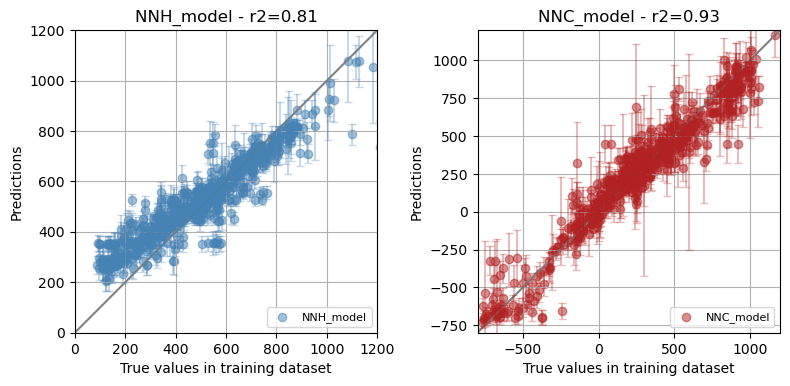

In [21]:
if Flag_Evaluation:

    from utils.postprocessing_evalutation import predict_bootstrap, plot_full_true_vs_pred

    X1_list, Y1_list, V1_list = [X1]*k_folds * \
        n_CVrepeats, [], [V1]*k_folds*n_CVrepeats
    X2_list, Z2_list, W2_list = [
        X2]*k_folds*n_CVrepeats, [Z2]*k_folds*n_CVrepeats, [W2]*k_folds*n_CVrepeats

    with concurrent.futures.ThreadPoolExecutor() as executor:
        future1 = executor.submit(predict_bootstrap, model_path_bo, NNH_model_name,
                                  X1_list, Y1_list, V1_list,
                                  k_folds, n_CVrepeats, mc_repeat,
                                  scalers["compo"], [], scalers["specific_features"], scalers["H_output"])

        future2 = executor.submit(predict_bootstrap, model_path_bo, NNC_model_name,
                                  X2_list, Z2_list, W2_list,
                                  k_folds, n_CVrepeats, mc_repeat,
                                  scalers["compo"], scalers["C_specific_testing"], scalers["specific_features"], scalers["C_output"])

    H1_pred_X1_stack, H1_pred_X1_mean, H1_pred_X1_std = future1.result()
    C2_pred_X2_stack, C2_pred_X2_mean, C2_pred_X2_std = future2.result()

    plot_full_true_vs_pred([H1, C2], [H1_pred_X1_stack, C2_pred_X2_stack],
                           model_path_bo, lims=[[0, 1200], [-800, 1200]])


## Predict based on new data inputs


### Coordinates for PVD alloy representation


In [22]:
if Flag_Prediction:
    # load the wafer-coordinates
    df_PVD_x_y = pd.read_excel(data_path + 'PVD_x_y.xlsx')
    coord_x = df_PVD_x_y["x"].to_numpy(dtype=float)
    coord_y = df_PVD_x_y["y"].to_numpy(dtype=float)
    index_PVD_x_y = df_PVD_x_y.index.values+1


### Make predictions for new alloys

- NiCrCoVFe_KW99
- NiCrMoTiFe_KW131


Processing:   0%|                                                                                               | 0/2 [00:00<?, ?it/s]

['Ni', 'Cr', 'Co', 'V', 'Fe']
NiCrCoVFe_KW99


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosi

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosi

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosi

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


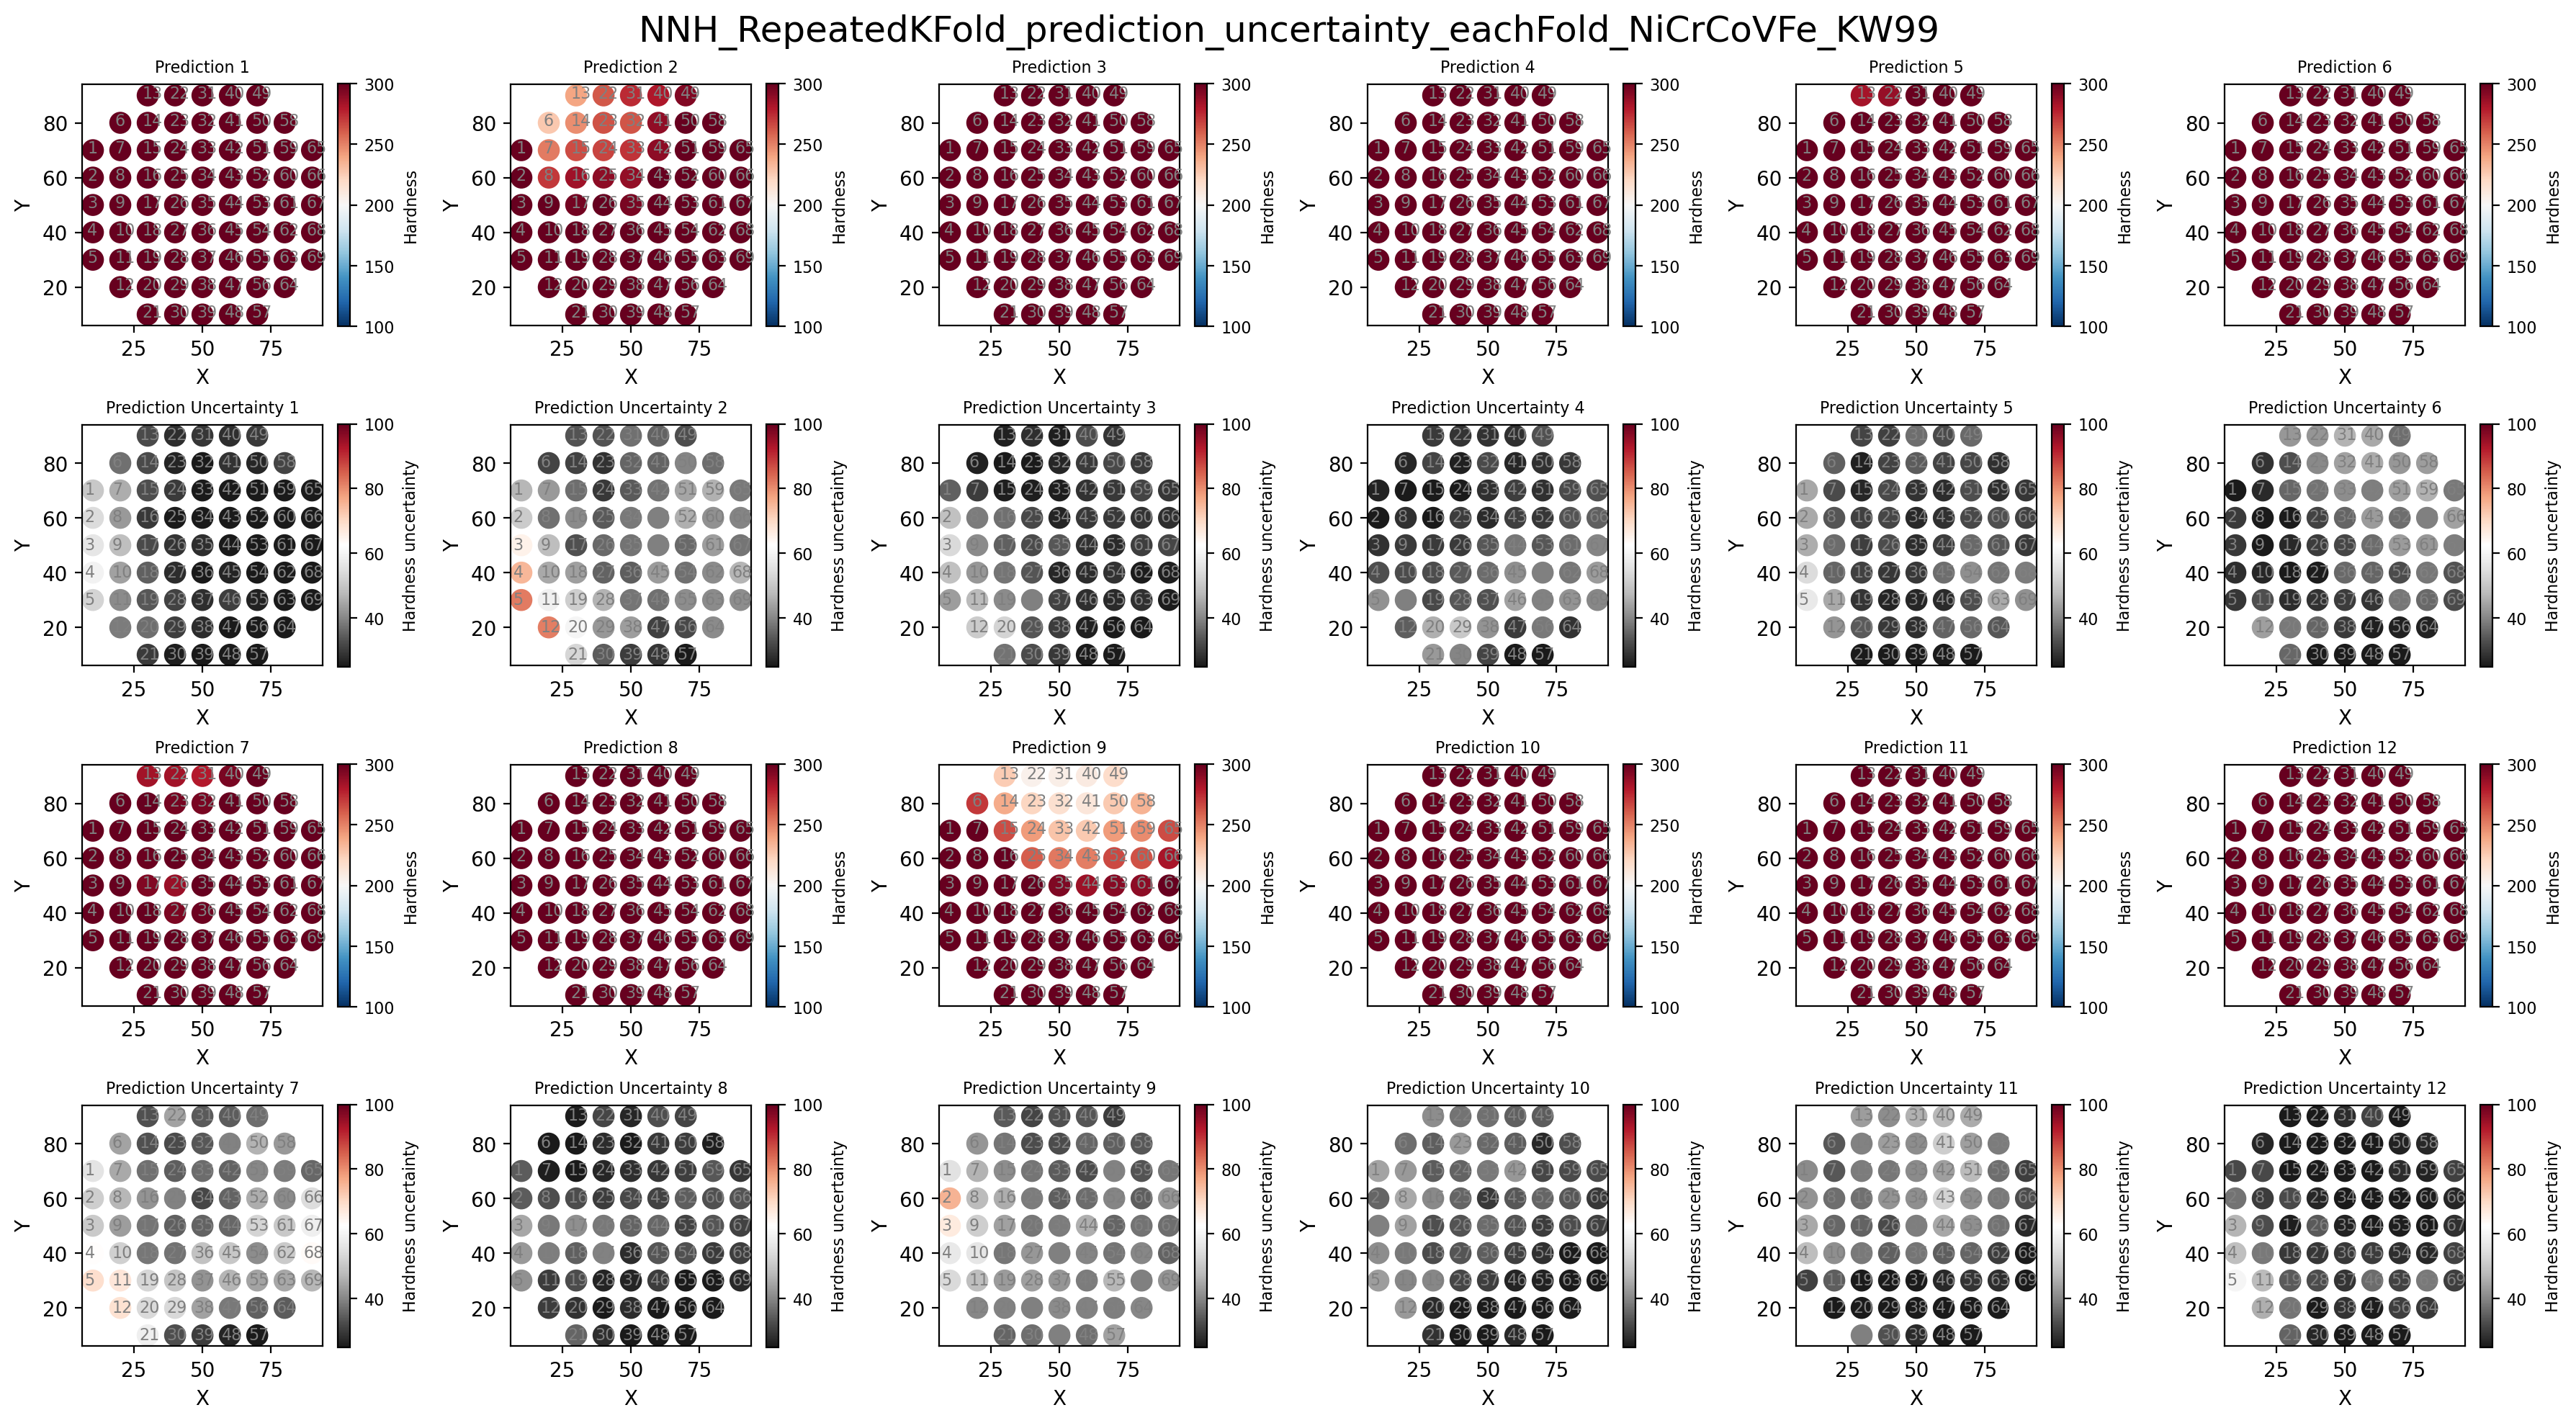

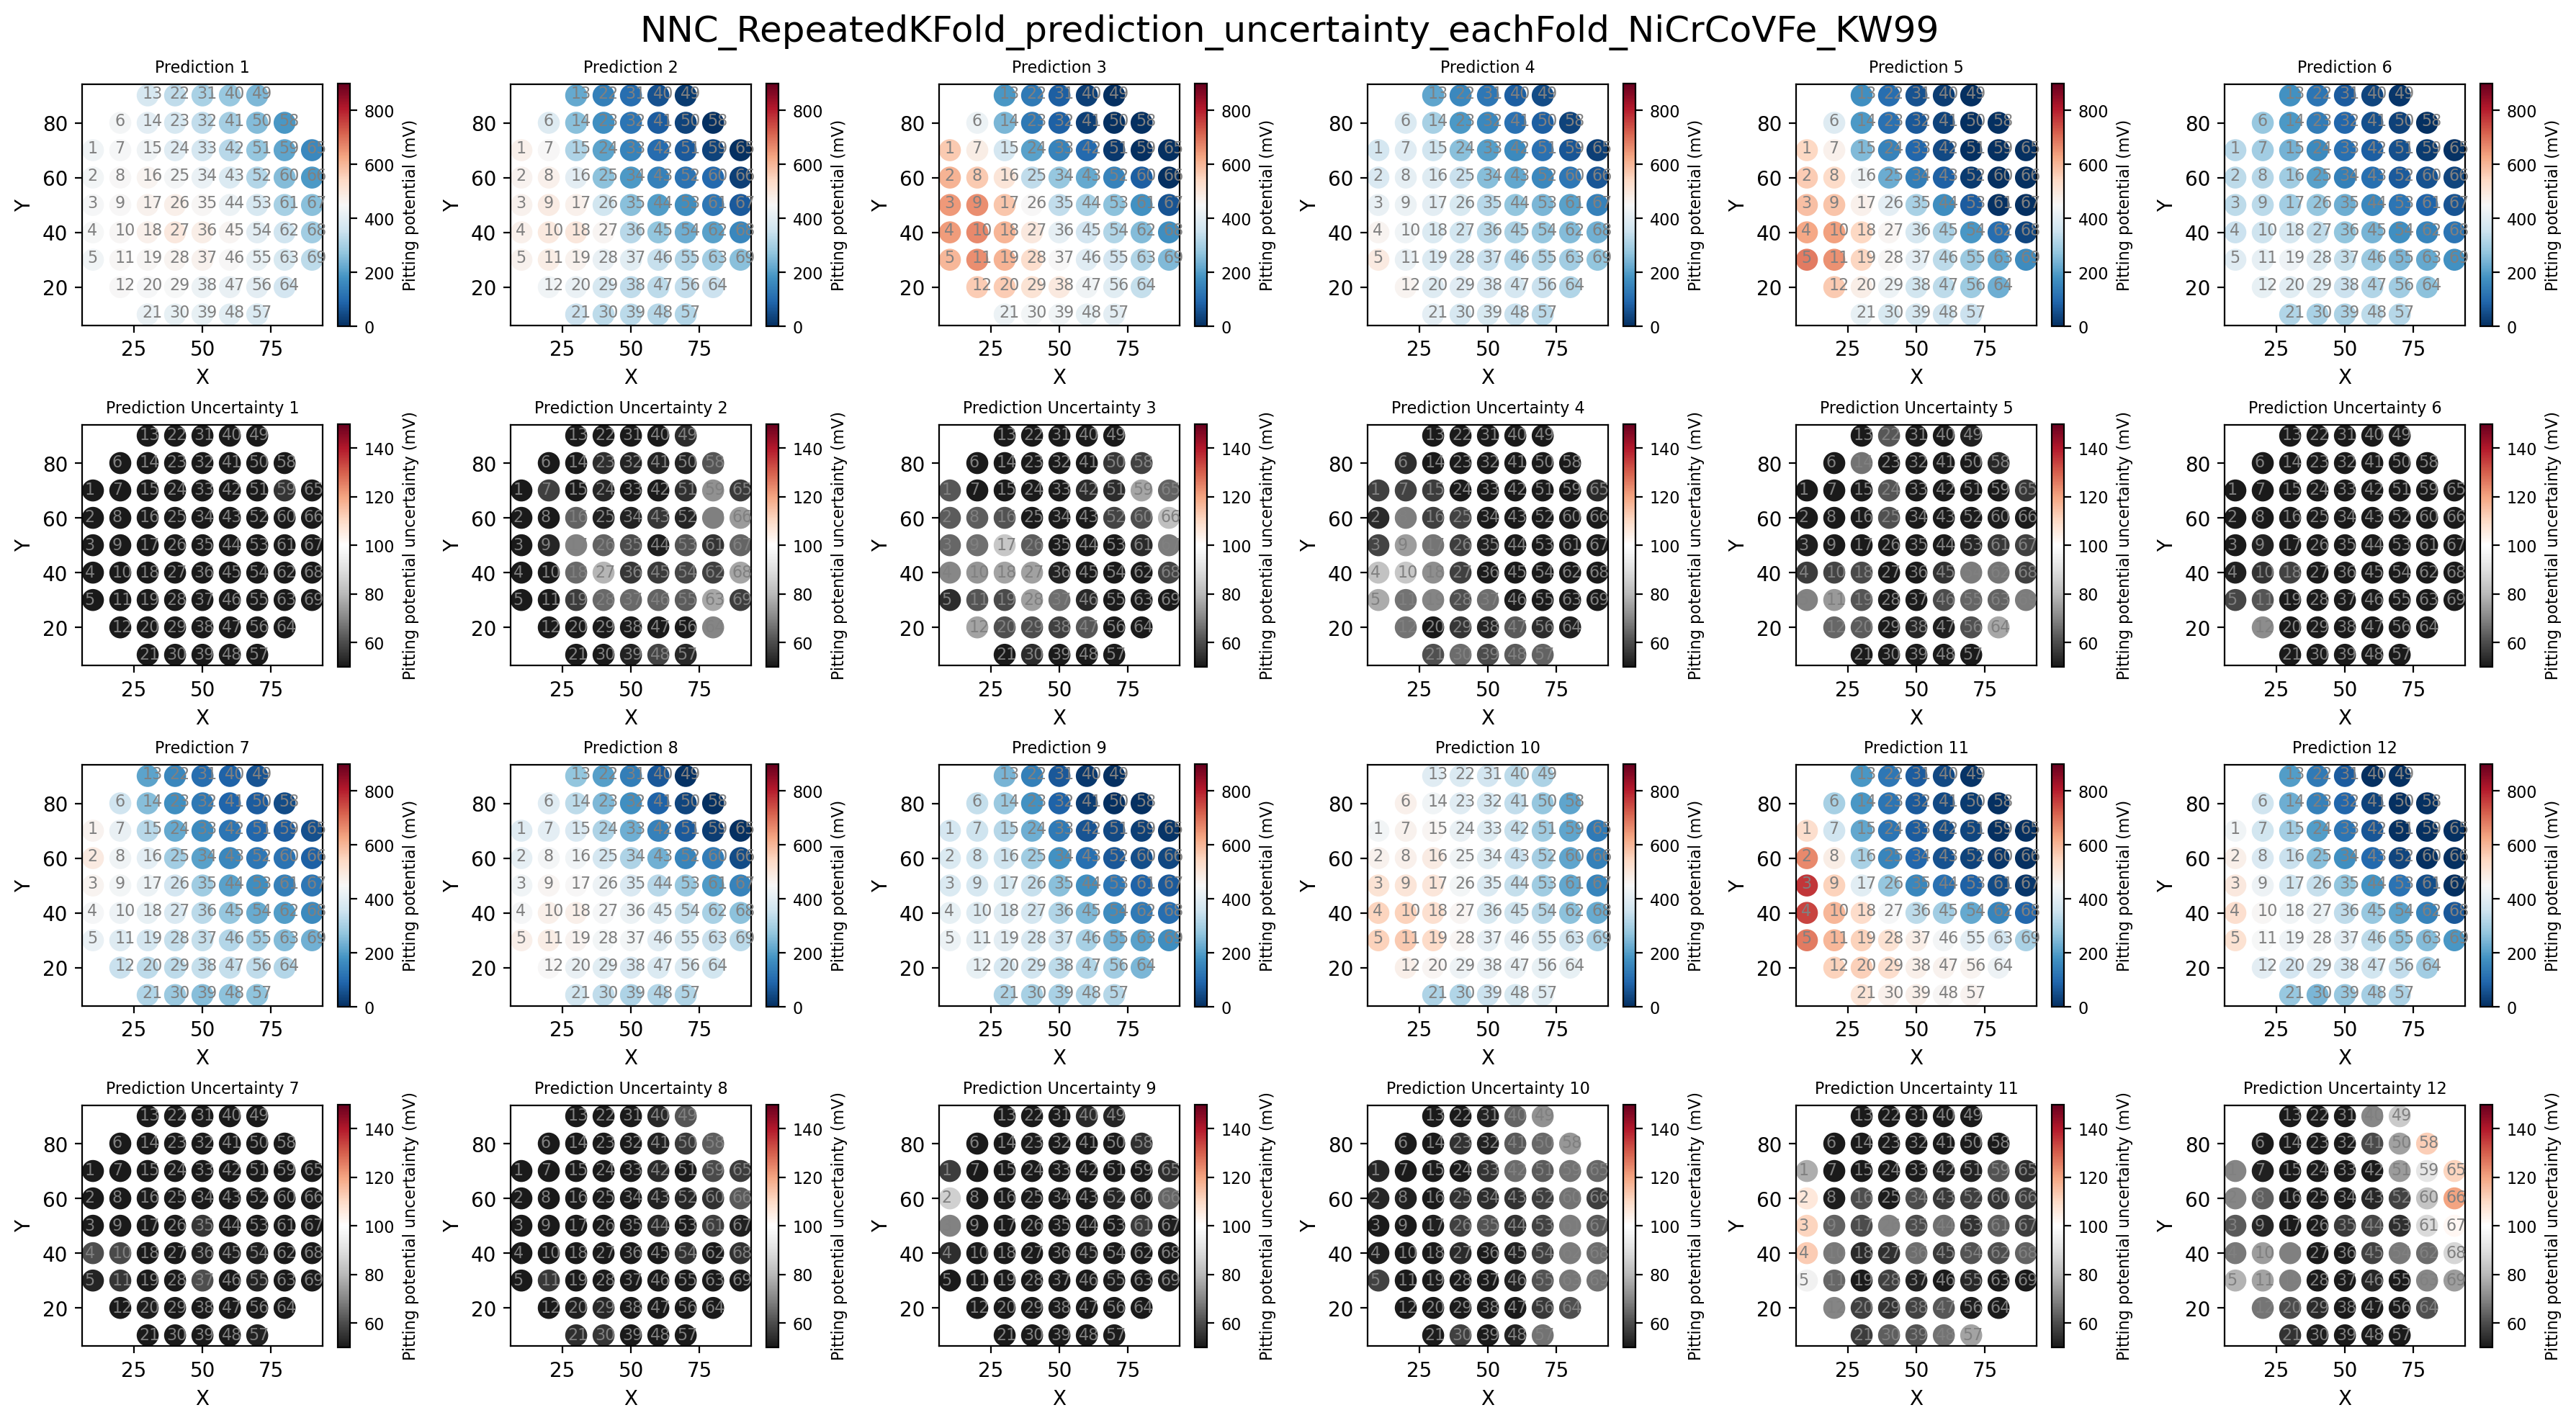

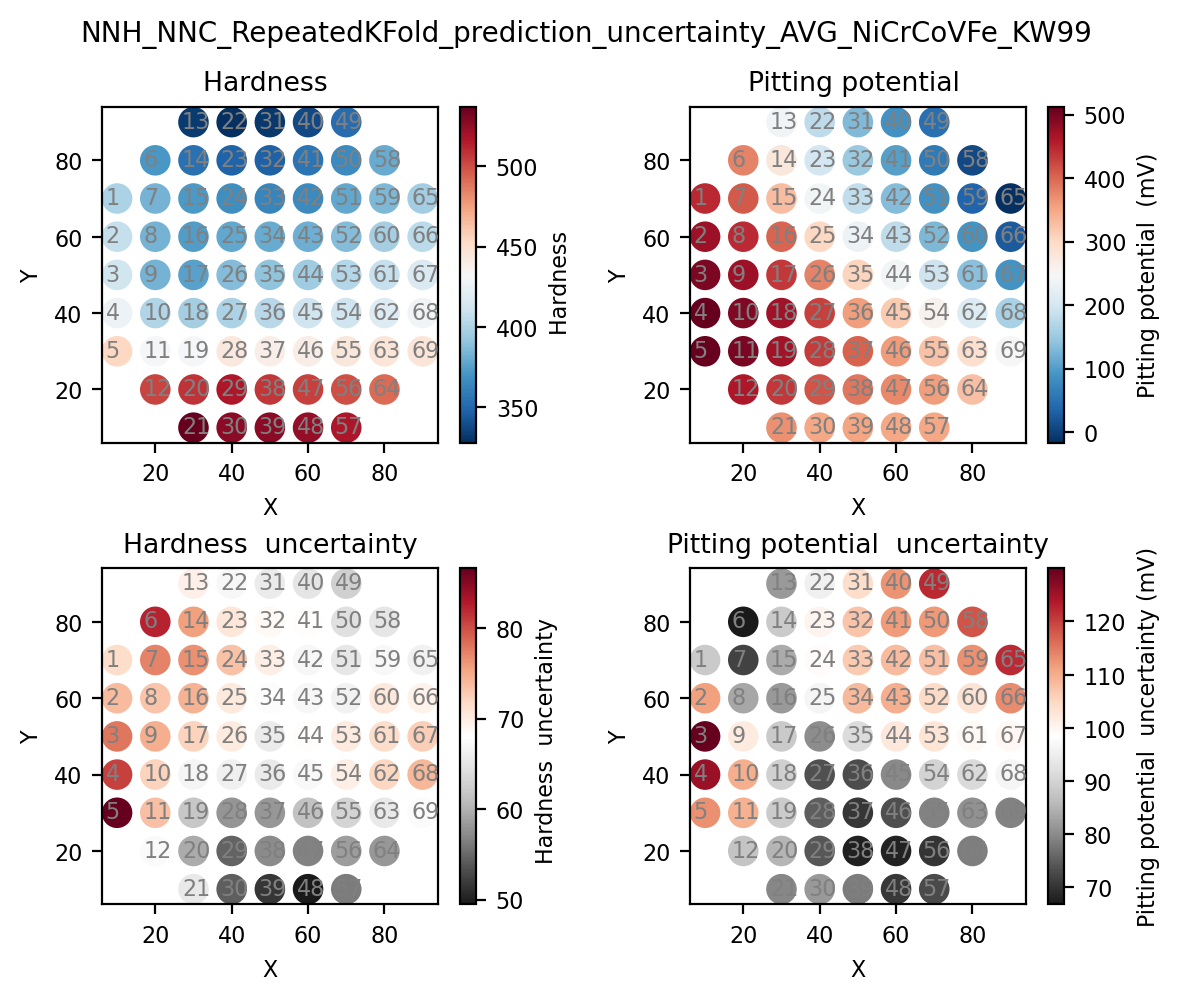

Processing:  50%|███████████████████████████████████████████▌                                           | 1/2 [01:38<01:38, 98.48s/it]

['Ni', 'Cr', 'Mo', 'Ti', 'Fe']
NiCrMoTiFe_KW131


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosi

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosi

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosi

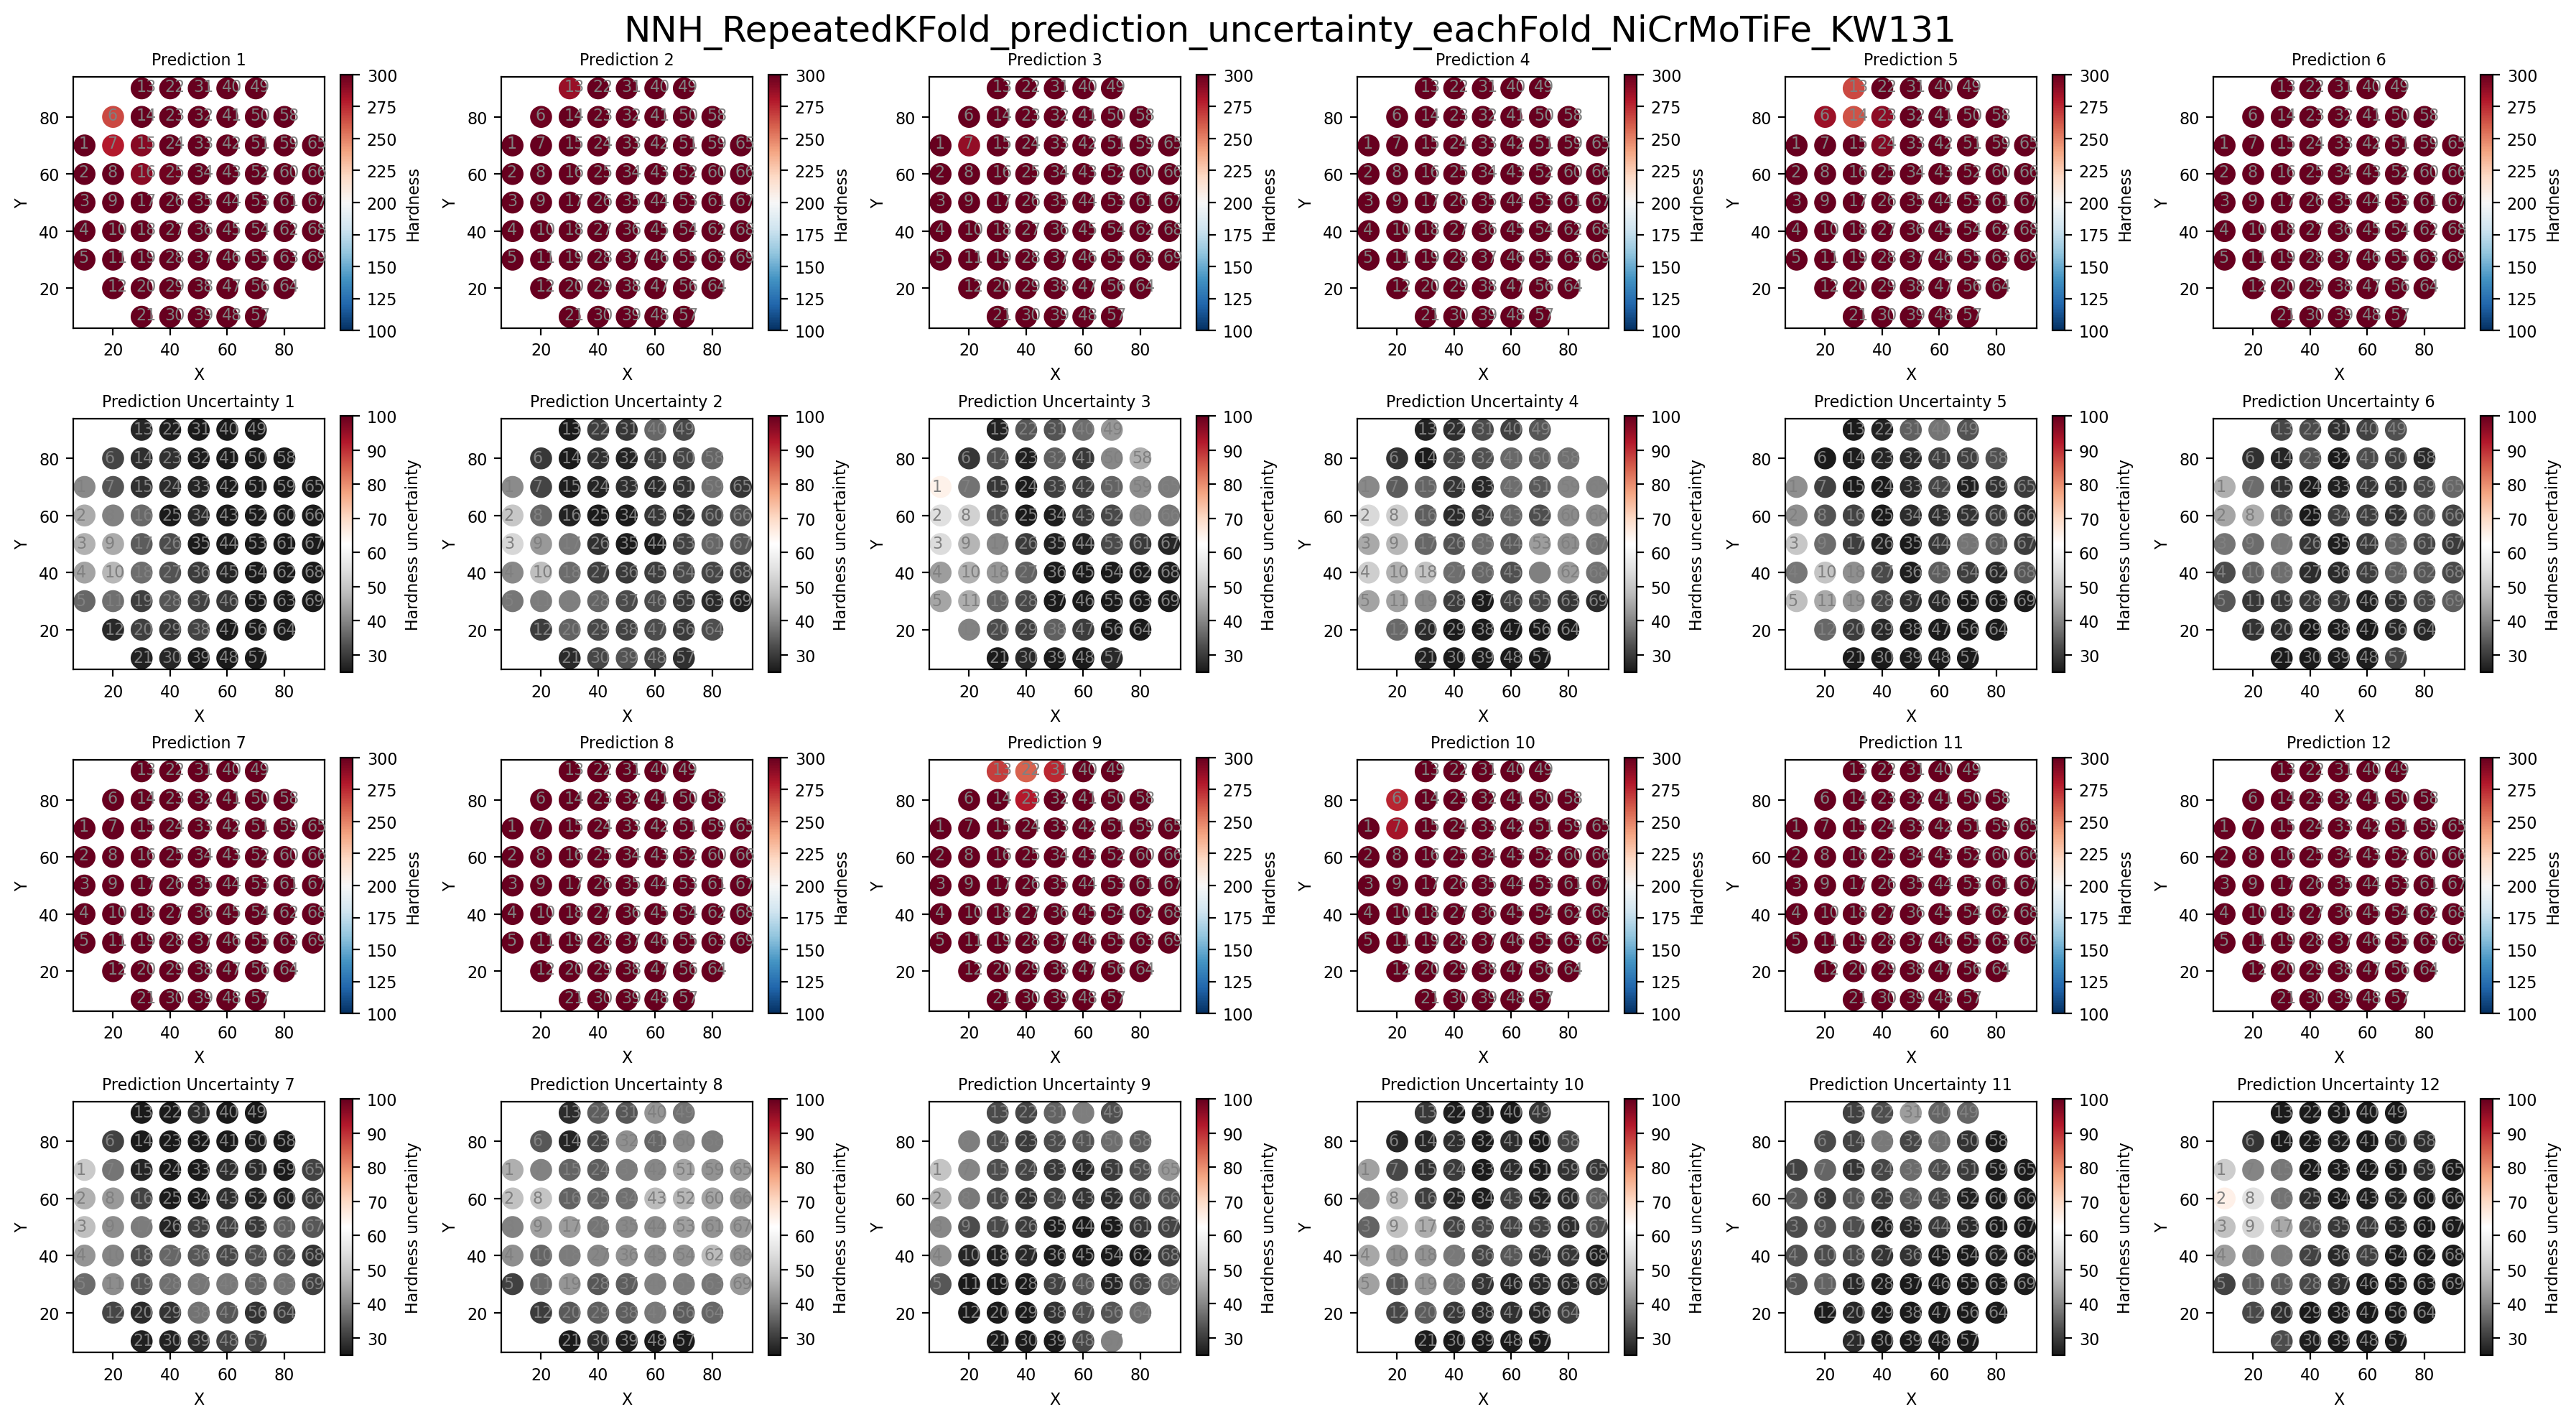

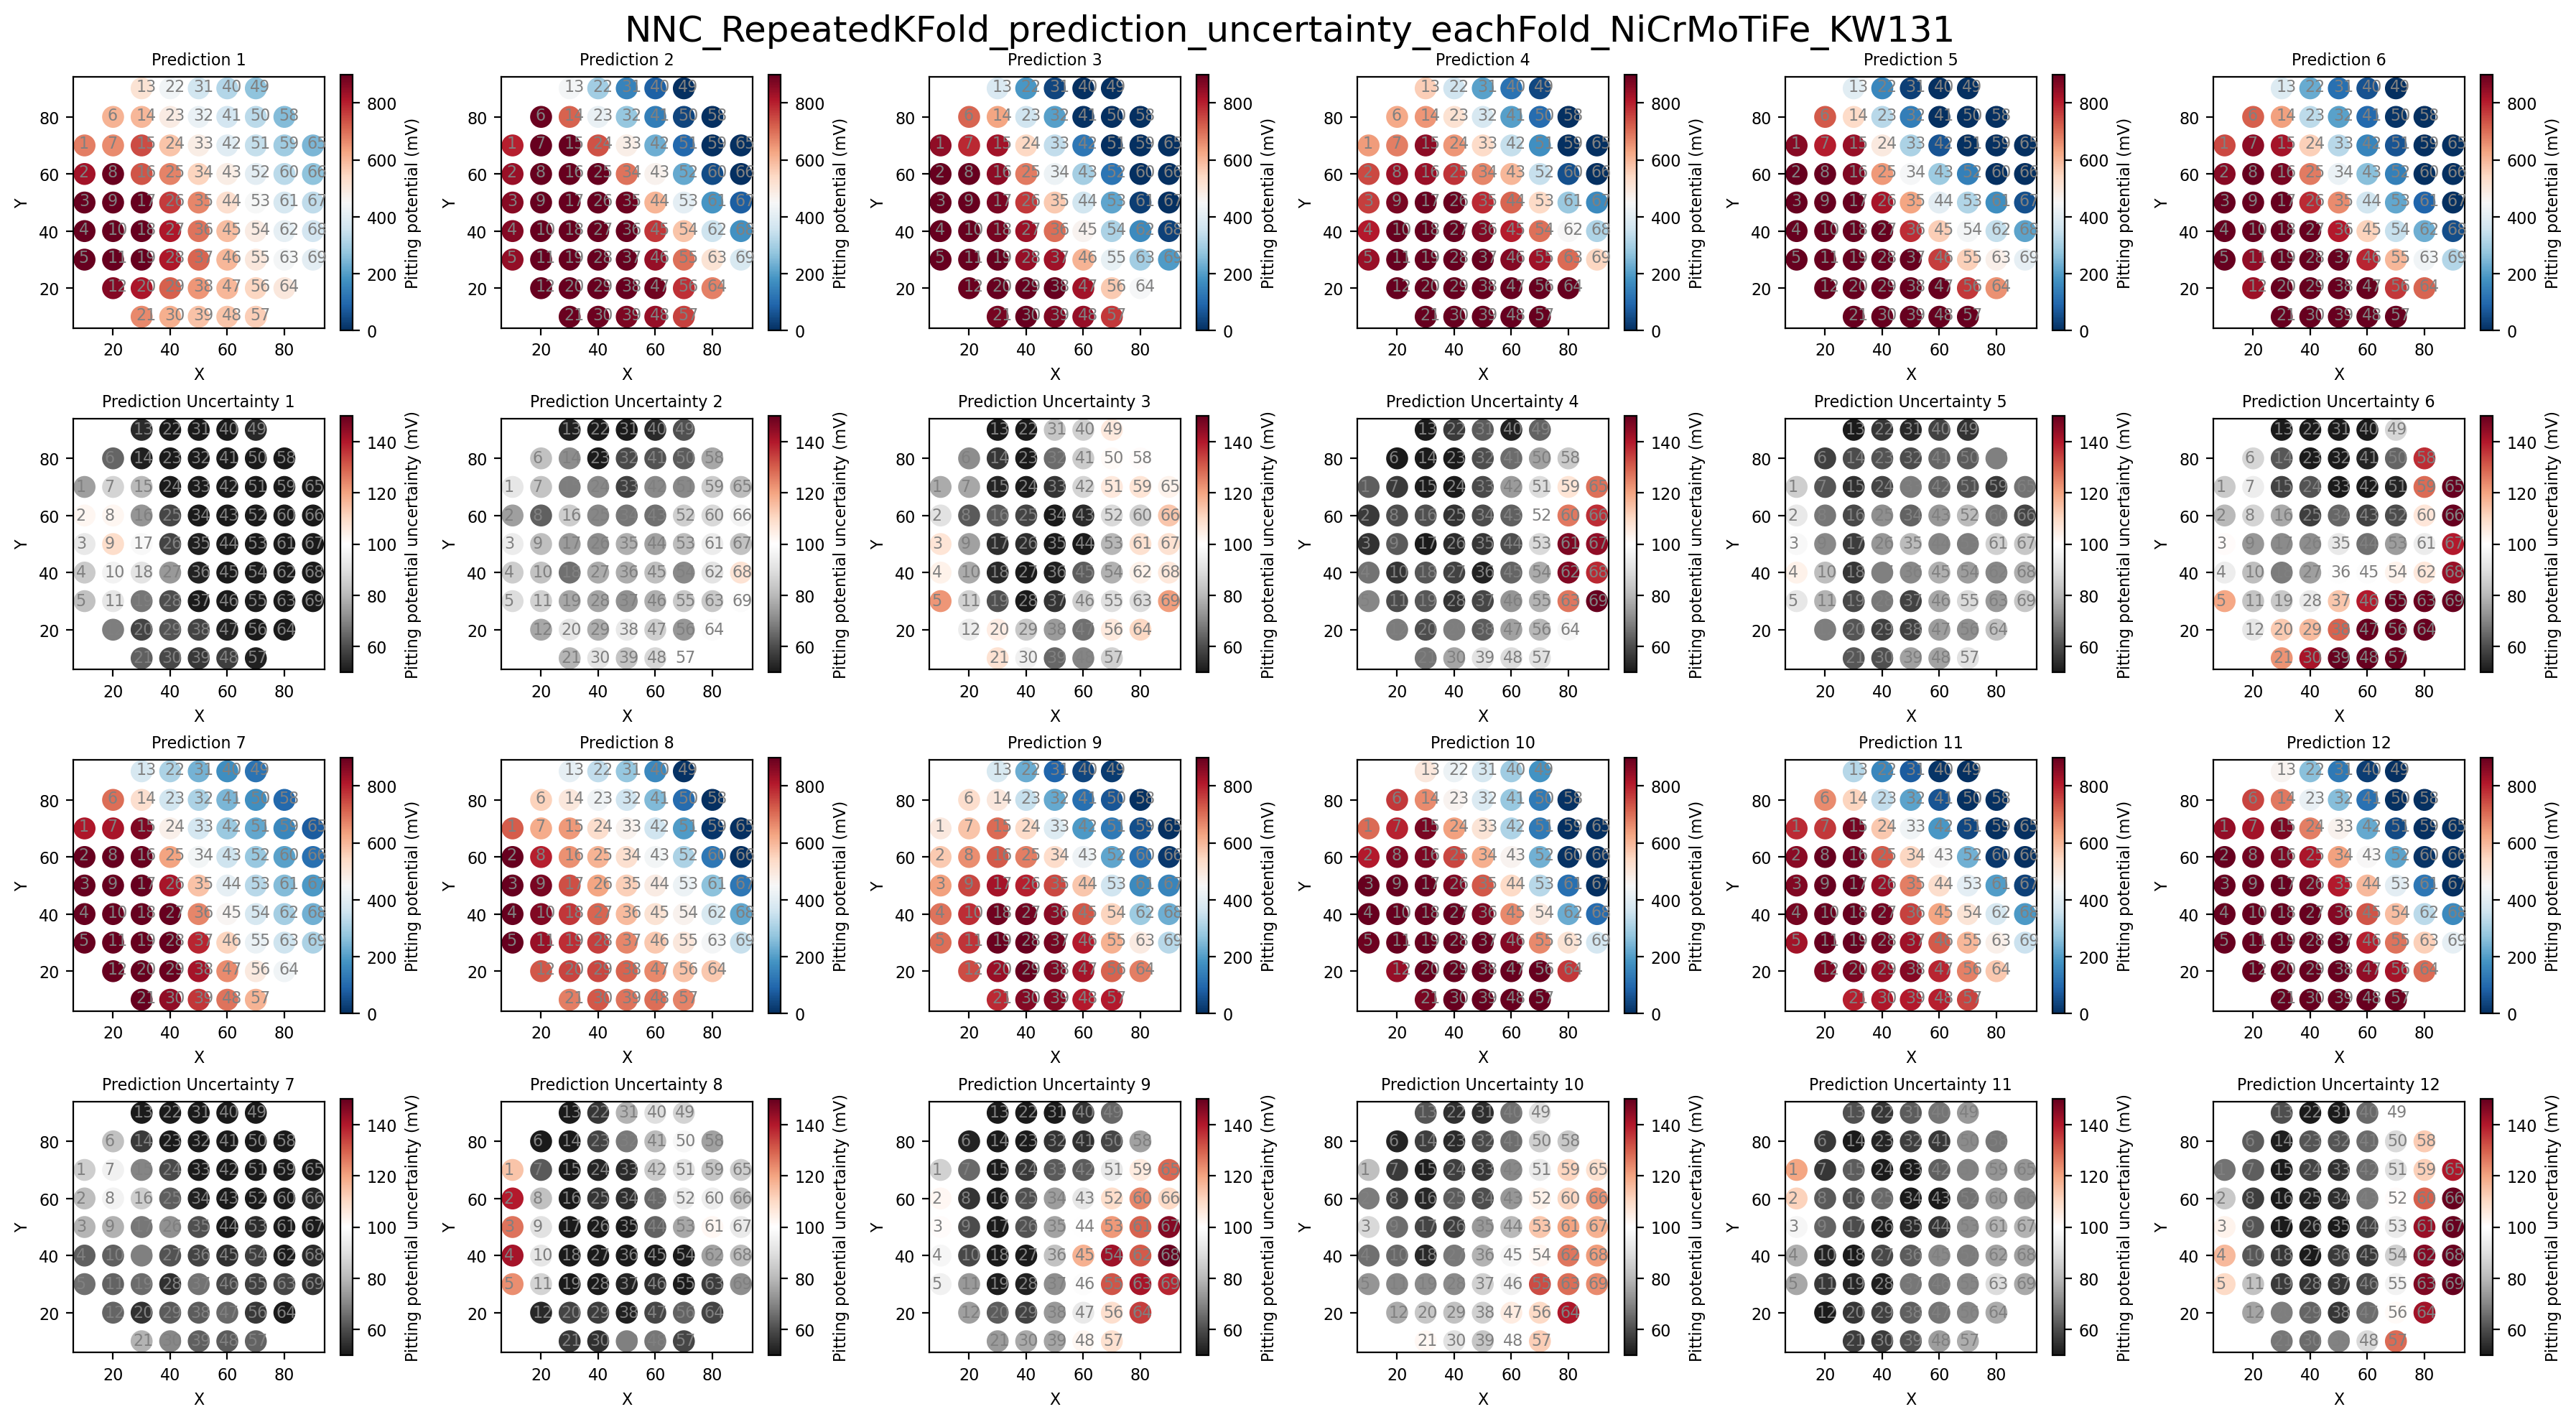

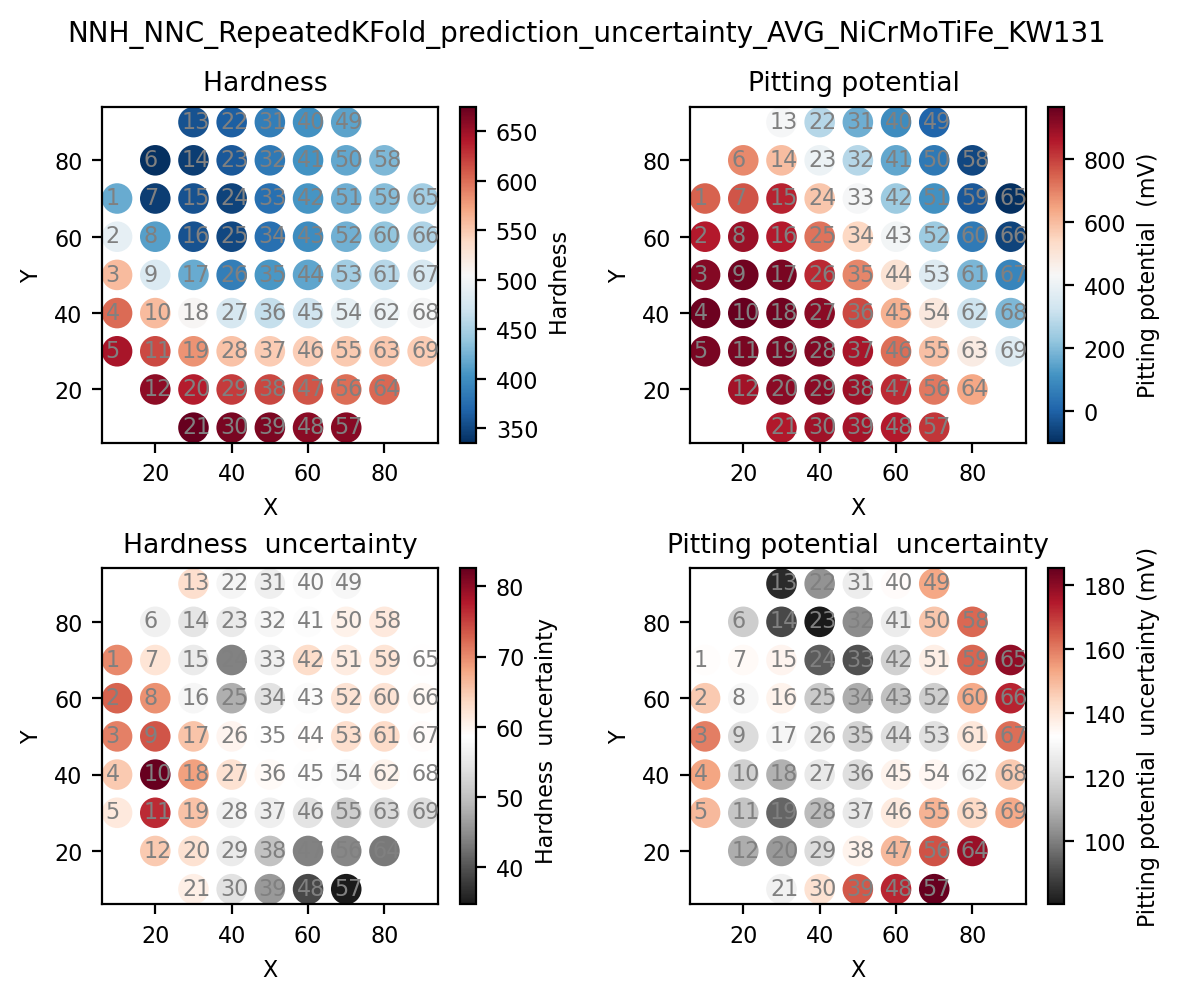

Processing: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2/2 [03:14<00:00, 96.95s/it]

Processing: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2/2 [03:14<00:00, 97.18s/it]

In [23]:
if Flag_Prediction:

    from utils.postprocessing_prediction import read_new_data_feature_calc, predict_bootstrap_NNH_NNC, plot_prediction_uncertainty, plot_prediction_uncertainty_AVG
    from tqdm import tqdm

    compo_A_B_C_D_E_list = [
        ['Ni', 'Cr', 'Co', 'V', 'Fe'], ['Ni', 'Cr', 'Mo', 'Ti', 'Fe']]
    compo_A_B_C_D_E_fname_list = ['NiCrCoVFe_KW99', 'NiCrMoTiFe_KW131']

    for compo_A_B_C_D_E, compo_A_B_C_D_E_fname in tqdm(zip(compo_A_B_C_D_E_list, compo_A_B_C_D_E_fname_list), desc='Processing', total=len(compo_A_B_C_D_E_list)):

        print(compo_A_B_C_D_E)
        print(compo_A_B_C_D_E_fname)

        vars_ele = compo_A_B_C_D_E
        KW_name = compo_A_B_C_D_E_fname
        file_name_input = f'{data_path}MultiTaskModel_{KW_name}_wt_pct.xlsx'
        df_new_wt = pd.read_excel(file_name_input)

        compo_new, HC_specific_features, C_specific_testing = read_new_data_feature_calc(df_new_wt, vars_ele,
                                                                                         specific_features_sel_column=['delta_a', 'Tm', 'sigma_Tm',
                                                                                                                       'Hmix', 'sigma_Hmix', 'sigma_elec_nega', 'VEC', 'sigma_VEC'],
                                                                                         C_testing=np.array([25, 1, 7, 0.333]))

        NNH_model_name = 'NNH_model_RepeatedKFold_{}.h5'
        NNC_model_name = 'NNC_model_RepeatedKFold_{}.h5'
        k_folds, n_CVrepeats, mc_repeat = 6, 2, 100

        (H1_new_pred_stack, H1_new_pred_mean, H1_new_pred_std,
         C2_new_pred_stack, C2_new_pred_mean, C2_new_pred_std) = predict_bootstrap_NNH_NNC(
            model_path_bo, NNH_model_name, NNC_model_name,
            compo_new, HC_specific_features, C_specific_testing,
            scalers, k_folds, n_CVrepeats, mc_repeat)

        # Concatenate and compute mean and std + save to excel
        H1_new_pred_KFold_mean = np.mean(np.concatenate(
            H1_new_pred_stack, axis=0), axis=0).reshape(-1)
        H1_new_pred_KFold_std = np.std(np.concatenate(
            H1_new_pred_stack, axis=0), axis=0).reshape(-1)
        C2_new_pred_KFold_mean = np.mean(np.concatenate(
            C2_new_pred_stack, axis=0), axis=0).reshape(-1)
        C2_new_pred_KFold_std = np.std(np.concatenate(
            C2_new_pred_stack, axis=0), axis=0).reshape(-1)

        df_new_wt['H1_new_pred_KFold_mean'] = H1_new_pred_KFold_mean
        df_new_wt['H1_new_pred_KFold_std'] = H1_new_pred_KFold_std
        df_new_wt['C2_new_pred_KFold_mean'] = C2_new_pred_KFold_mean
        df_new_wt['C2_new_pred_KFold_std'] = C2_new_pred_KFold_std

        file_name_output = f'{model_path_bo}MultiTaskModel_{KW_name}_wt_pct_ML.xlsx'
        df_new_wt.to_excel(file_name_output, index=False)

        # NNH predictions
        plot_prediction_uncertainty(model_path_bo, coord_x, coord_y, index_PVD_x_y, H1_new_pred_mean, H1_new_pred_std,
                                    pred_label='Hardness', unc_label='Hardness uncertainty',
                                    title='NNH_RepeatedKFold_prediction_uncertainty_eachFold_' + KW_name,
                                    vmin1=100, vmax1=300,
                                    vmin2=25, vmax2=100)

        # NNC predictions
        plot_prediction_uncertainty(model_path_bo, coord_x, coord_y, index_PVD_x_y, C2_new_pred_mean, C2_new_pred_std,
                                    pred_label='Pitting potential (mV)', unc_label='Pitting potential uncertainty (mV)',
                                    title='NNC_RepeatedKFold_prediction_uncertainty_eachFold_' + KW_name,
                                    vmin1=0, vmax1=900,
                                    vmin2=50, vmax2=150)

        # NNH_NNC_AVG predictions
        plot_prediction_uncertainty_AVG(model_path_bo, coord_x, coord_y, index_PVD_x_y, H1_new_pred_stack, C2_new_pred_stack,
                                        title='NNH_NNC_RepeatedKFold_prediction_uncertainty_AVG_' + KW_name)
